# HOSPITAL STAR RATING SYSTEM:

### IMPORTING LIBRARIES:

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the numpy and pandas packages

import numpy as np
import pandas as pd

# Importing other required libraries
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# visulaisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
%matplotlib inline

### READING DATA FILES AND INSPECTION:

Here, we have two types of measures: - positive and negative. Identifying the direction of each measure in each of the 7 groups is important.

The groups having measures with negative direction are 'readmission', 'mortality', 'medical imaging', 'safety', 'timeliness'. All negetive measures are 'lower the better'. Eg. measures in 'Mortality' indicate the death rate. Hence, all the dataframes with negative measures will be multiplied by (-1) to reverse the direction of respective scores. This can be interpreted in such a way that +1 indicates good and -1 indicates bad. 

The groups having measures with positive direction are 'Effectiveness'. These measures can be used as it is. 

Once this is done, the data will be standardized. 

In [3]:
# Read the csv file 'Readmissions and Deaths - Hospital'
df1 = pd.read_csv('Readmissions and Deaths - Hospital.csv')
df1.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015


In [4]:
# Replacing 'Not Available' with NaN
df1 = df1.replace('Not Available',np.nan)

In [5]:
# Getting basic info of dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67452 entries, 0 to 67451
Data columns (total 18 columns):
Provider ID             67452 non-null int64
Hospital Name           67452 non-null object
Address                 67452 non-null object
City                    67452 non-null object
State                   67452 non-null object
ZIP Code                67452 non-null int64
County Name             67242 non-null object
Phone Number            67452 non-null int64
Measure Name            67452 non-null object
Measure ID              67452 non-null object
Compared to National    52902 non-null object
Denominator             41710 non-null object
Score                   41710 non-null object
Lower Estimate          41710 non-null object
Higher Estimate         41710 non-null object
Footnote                25742 non-null object
Measure Start Date      67452 non-null object
Measure End Date        67452 non-null object
dtypes: int64(3), object(15)
memory usage: 9.3+ MB


In [6]:
# Individual measure count for each 'Measure ID'
df1['Measure ID'].value_counts().sort_values(ascending=False)

MORT_30_STK           4818
MORT_30_PN            4818
READM_30_HF           4818
MORT_30_CABG          4818
MORT_30_AMI           4818
READM_30_HOSP_WIDE    4818
READM_30_CABG         4818
READM_30_HIP_KNEE     4818
MORT_30_COPD          4818
READM_30_COPD         4818
READM_30_AMI          4818
READM_30_PN           4818
READM_30_STK          4818
MORT_30_HF            4818
Name: Measure ID, dtype: int64

In [7]:
# Coverting datatype of 'Score' to float
df1["Score"] = pd.to_numeric(df1["Score"])

# Creating new dataframe of only required features
df11 = df1[['Provider ID', 'Measure ID', 'Score']]
df11.head(2)

,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2


In [8]:
# Getting a pivot table with measures as columns/ features
df11 = df11.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df11.head()

Score                                                  \
Measure ID  MORT_30_AMI MORT_30_CABG MORT_30_COPD MORT_30_HF MORT_30_PN   
Provider ID                                                               
10001              12.5          4.2          9.3       12.4       15.5   
10005              16.0          NaN          7.6       15.5       20.8   
10006              16.7          4.1          7.1       15.6       18.2   
10007               NaN          NaN          9.3       14.4       18.8   
10008               NaN          NaN          8.2       12.7       15.7   

                                                                              \
Measure ID  MORT_30_STK READM_30_AMI READM_30_CABG READM_30_COPD READM_30_HF   
Provider ID                                                                    
10001              15.4         16.5          15.1          21.1        21.4   
10005              15.5         16.7           NaN          18.0        21.9   
10006              17.9         16.1          15.2          19.8        20.6   
10007              16.6          NaN           NaN          19.9        21.1   
10008               NaN          NaN           NaN          19.2        23.1   

                                                                           
Measure ID  READM_30_HIP_KNEE READM_30_HOSP_WIDE READM_30_PN READM_30_STK  
Provider ID                                                                
10001                     5.1               15.4        18.7         12.7  
10005                     5.7               14.9        16.4         13.4  
10006                     5.0               15.4        17.9         12.0  
10007                     NaN               16.6        17.3         12.7  
10008                     NaN               15.7        16.0          NaN

In [9]:
# Changing the direction of the values
df11 = df11.apply(lambda x: x * -1)

In [10]:
# Read the csv file 'Timely and Effective Care - Hospital'
df2 = pd.read_csv('Timely and Effective Care - Hospital.csv')
df2.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure ID,Measure Name,Score,Sample,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_7a,Fibrinolytic Therapy Received Within 30 Minute...,Not Available,Not Available,7 - No cases met the criteria for this measure.,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_8a,Primary PCI Received Within 90 Minutes of Hosp...,92,24,3 - Results are based on a shorter time period...,01/01/2015,09/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Children's Asthma,CAC_3,Home Management Plan of Care Document,Not Available,Not Available,5 - Results are not available for this reporti...,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,269,535,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,68,535,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015


In [11]:
# Individual measure count for each 'Measure ID'
df2['Measure ID'].value_counts().sort_values(ascending=False)

OP_3b                     4818
VTE_5                     4818
AMI_7a                    4818
OP_2                      4818
PC_01                     4818
STK_2                     4818
ED_2b                     4818
SCIP_INF_9                4818
ED_1b                     4818
SCIP_INF_1                4818
SCIP_INF_2                4818
VTE_1                     4818
OP_30                     4818
STK_10                    4818
STK_6                     4818
OP_18b                    4818
PN_6                      4818
OP_1                      4818
VTE_4                     4818
CAC_3                     4818
OP_21                     4818
STK_1                     4818
STK_4                     4818
AMI_8a                    4818
OP_23                     4818
SCIP_CARD_2               4818
STK_3                     4818
OP_29                     4818
VTE_6                     4818
EDV                       4818
OP_4                      4818
OP_5                      4818
OP_20   

In [12]:
# Dropping those 'Measure ID' which are not listed in the related pdf file, retaining only the required 'Measure ID'

df2.drop(df2[(df2['Measure ID'] == 'STK_5') | (df2['Measure ID'] == 'SCIP_INF_1') |
             (df2['Measure ID'] == 'OP_29') | (df2['Measure ID'] == 'HF_2') | 
             (df2['Measure ID'] == 'STK_2') | (df2['Measure ID'] == 'SCIP_CARD_2') |
             (df2['Measure ID'] == 'SCIP_INF_2') | (df2['Measure ID'] == 'OP_30') | 
             (df2['Measure ID'] == 'AMI_8a') | (df2['Measure ID'] == 'SCIP_INF_9') |
             (df2['Measure ID'] == 'OP_2') | (df2['Measure ID'] == 'PN_6') |
             (df2['Measure ID'] == 'AMI_7a') | (df2['Measure ID'] == 'STK_3') | 
             (df2['Measure ID'] == 'STK_10') | (df2['Measure ID'] == 'SCIP_INF_3') |
             (df2['Measure ID'] == 'OP_1') | (df2['Measure ID'] == 'VTE_4') |
             (df2['Measure ID'] == 'EDV') |(df2['Measure ID'] == 'SCIP_VTE_2')].index, inplace = True) 

In [13]:
# Replacing 'Not Available' with NaN
df2 = df2.replace('Not Available',np.nan)

In [14]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)
 
df2['Measure ID']=df2['Measure ID'].replace('OP_3b','OP_3')
df2['Measure ID']=df2['Measure ID'].replace('IMM_3_OP_27_FAC_ADHPCT','IMM_3_OP_27')

In [15]:
# Getting basic info of dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110814 entries, 2 to 207173
Data columns (total 16 columns):
Provider ID           110814 non-null int64
Hospital Name         110814 non-null object
Address               110814 non-null object
City                  110814 non-null object
State                 110814 non-null object
ZIP Code              110814 non-null int64
County Name           110469 non-null object
Phone Number          110814 non-null int64
Condition             110814 non-null object
Measure ID            110814 non-null object
Measure Name          110814 non-null object
Score                 58647 non-null object
Sample                58649 non-null object
Footnote              79590 non-null object
Measure Start Date    110814 non-null object
Measure End Date      110814 non-null object
dtypes: int64(3), object(13)
memory usage: 14.4+ MB


In [16]:
# Coverting datatype of 'Score' to float
df2["Score"] = pd.to_numeric(df2["Score"])

# Creating new dataframe of only required features
df22 = df2[['Provider ID', 'Measure ID', 'Score']]
df22.head()

,Provider ID,Measure ID,Score
2,10001,CAC_3,NaN
3,10001,ED_1b,269.0
4,10001,ED_2b,68.0
7,10001,IMM_2,97.0
8,10001,IMM_3_OP_27,81.0


In [17]:
# Getting a pivot table with measures as columns/ features
df22 = df22.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df22.head()

Score                                                           \
Measure ID  CAC_3  ED_1b ED_2b  IMM_2 IMM_3_OP_27 OP_18b OP_20 OP_21 OP_22   
Provider ID                                                                  
10001         NaN  269.0  68.0   97.0        81.0  196.0  65.0  99.0   4.0   
10005         NaN  243.0  71.0   99.0        83.0  117.0  27.0  60.0   2.0   
10006         NaN  217.0  78.0  100.0        87.0  133.0  10.0  58.0   1.0   
10007         NaN  219.0  68.0   99.0        53.0  119.0  38.0  90.0   1.0   
10008         NaN  180.0  56.0   95.0        43.0   98.0  27.0  49.0   1.0   

                   ...                                                    \
Measure ID  OP_23  ... PC_01 STK_1 STK_4 STK_6  STK_8 VTE_1 VTE_2  VTE_3   
Provider ID        ...                                                     
10001         NaN  ...   0.0  99.0  67.0  99.0   87.0  97.0  99.0   91.0   
10005        86.0  ...   1.0  98.0   NaN  88.0  100.0  95.0  94.0  100.0   
10006         NaN  ...   0.0  99.0   NaN  97.0   90.0  98.0  89.0   86.0   
10007         NaN  ...   NaN  80.0   NaN  71.0    NaN  97.0  99.0    NaN   
10008         NaN  ...   NaN   NaN   NaN   NaN    NaN  99.0   NaN    NaN   

                          
Measure ID   VTE_5 VTE_6  
Provider ID               
10001         90.0   0.0  
10005        100.0   NaN  
10006         92.0   0.0  
10007          NaN   NaN  
10008          NaN   NaN  

[5 rows x 23 columns]

In [18]:
# Changing the direction of the values
df22 = df22.apply(lambda x: x * -1)

In [19]:
# Read the csv file 'Outpatient Imaging Efficiency - Hospital'
df3 = pd.read_csv('Outpatient Imaging Efficiency - Hospital.csv')
df3.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure ID,Measure Name,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_10,Abdomen CT Use of Contrast Material,6.4,NaN,07/01/2014,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_11,Thorax CT Use of Contrast Material,0.9,NaN,07/01/2014,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_13,Outpatients who got cardiac imaging stress tes...,7.1,NaN,07/01/2014,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_14,Outpatients with brain CT scans who got a sinu...,2.4,NaN,07/01/2014,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_8,MRI Lumbar Spine for Low Back Pain,38.1,NaN,07/01/2014,06/30/2015


In [20]:
# Individual measure count for each 'Measure ID'
df3['Measure ID'].value_counts().sort_values(ascending=False)

OP_11    4818
OP_9     4818
OP_8     4818
OP_14    4818
OP_13    4818
OP_10    4818
Name: Measure ID, dtype: int64

In [21]:
# Dropping those 'Measure ID' which are not listed in the related pdf file, retaining only the required 'Measure ID'
df3.drop(df3[(df3['Measure ID'] == 'OP_9')].index, inplace = True) 

In [22]:
# Replacing 'Not Available' with NaN
df3 = df3.replace('Not Available',np.nan)

In [23]:
# Getting basic info of dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24090 entries, 0 to 28906
Data columns (total 14 columns):
Provider ID           24090 non-null int64
Hospital Name         24090 non-null object
Address               24090 non-null object
City                  24090 non-null object
State                 24090 non-null object
ZIP Code              24090 non-null int64
County Name           24015 non-null object
Phone Number          24090 non-null int64
Measure ID            24090 non-null object
Measure Name          24090 non-null object
Score                 13039 non-null object
Footnote              11051 non-null object
Measure Start Date    24090 non-null object
Measure End Date      24090 non-null object
dtypes: int64(3), object(11)
memory usage: 2.8+ MB


In [24]:
# Coverting datatype of 'Score' to float
df3["Score"] = pd.to_numeric(df3["Score"])

# Creating new dataframe of only required features
df33 = df3[['Provider ID', 'Measure ID', 'Score']]
df33.head()

,Provider ID,Measure ID,Score
0,10001,OP_10,6.4
1,10001,OP_11,0.9
2,10001,OP_13,7.1
3,10001,OP_14,2.4
4,10001,OP_8,38.1


In [25]:
# Getting a pivot table with measures as columns/ features
df33 = df33.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df33.head()

Score                        
Measure ID  OP_10 OP_11 OP_13 OP_14  OP_8
Provider ID                              
10001         6.4   0.9   7.1   2.4  38.1
10005        13.3  10.2   5.3   4.0  42.8
10006        11.8   4.6   0.0   4.6  45.6
10007        24.3   6.1   NaN   NaN   NaN
10008         3.6   NaN   NaN   0.6   NaN

In [26]:
# Changing the direction of the values
df33 = df33.apply(lambda x: x * -1)

In [27]:
# Read the csv file 'Healthcare Associated Infections - Hospital'
df4 = pd.read_csv('Healthcare Associated Infections - Hospital.csv')
df4.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Lower Confidence Limit,HAI_1_CI_LOWER,NaN,1.03,NaN,1/1/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Upper Confidence Limit,HAI_1_CI_UPPER,NaN,2.765,NaN,1/1/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Number of Device Days,HAI_1_DOPC_DAYS,NaN,7117,NaN,1/1/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Predicted Cases,HAI_1_ELIGCASES,NaN,9.198,NaN,1/1/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Observed Cases,HAI_1_NUMERATOR,NaN,16,NaN,1/1/2015,12/31/2015


In [28]:
# Individual measure count for each 'Measure ID'
df4['Measure ID'].value_counts().sort_values(ascending=False)

HAI_2a_SIR          4818
HAI_5_NUMERATOR     4818
HAI_6_SIR           4818
HAI_5_DOPC_DAYS     4818
HAI_4_SIR           4818
HAI_4_CI_LOWER      4818
HAI_5_ELIGCASES     4818
HAI_6_DOPC_DAYS     4818
HAI_5_CI_LOWER      4818
HAI_1_NUMERATOR     4818
HAI_3_SIR           4818
HAI_2a_NUMERATOR    4818
HAI_2_CI_LOWER      4818
HAI_3_ELIGCASES     4818
HAI_1_CI_UPPER      4818
HAI_2_DOPC_DAYS     4818
HAI_2a_DOPC_DAYS    4818
HAI_1a_ELIGCASES    4818
HAI_3_DOPC_DAYS     4818
HAI_1a_CI_UPPER     4818
HAI_2_CI_UPPER      4818
HAI_6_ELIGCASES     4818
HAI_1_DOPC_DAYS     4818
HAI_2a_CI_UPPER     4818
HAI_5_SIR           4818
HAI_1a_CI_LOWER     4818
HAI_1_CI_LOWER      4818
HAI_3_CI_UPPER      4818
HAI_1_SIR           4818
HAI_2a_CI_LOWER     4818
HAI_2_ELIGCASES     4818
HAI_6_CI_UPPER      4818
HAI_1a_NUMERATOR    4818
HAI_2_SIR           4818
HAI_4_DOPC_DAYS     4818
HAI_4_CI_UPPER      4818
HAI_5_CI_UPPER      4818
HAI_6_CI_LOWER      4818
HAI_4_ELIGCASES     4818
HAI_6_NUMERATOR     4818


In [29]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_NUMERATOR','HAI_5')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_DOPC_DAYS','HAI_5')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_SIR','HAI_5')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_CI_UPPER','HAI_5')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_CI_LOWER','HAI_5')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_5_ELIGCASES','HAI_5')

In [30]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_NUMERATOR','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_SIR','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_CI_LOWER','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_ELIGCASES','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_CI_UPPER','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_CI_LOWER','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_DOPC_DAYS','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_NUMERATOR','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_SIR','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2a_CI_UPPER','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_DOPC_DAYS','HAI_2')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_2_ELIGCASES','HAI_2')

In [31]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_CI_UPPER','HAI_6')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_SIR','HAI_6')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_ELIGCASES','HAI_6')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_NUMERATOR','HAI_6')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_CI_LOWER','HAI_6')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_6_DOPC_DAYS','HAI_6')

In [32]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_DOPC_DAYS','HAI_3')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_CI_UPPER','HAI_3')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_ELIGCASES','HAI_3')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_SIR','HAI_3')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_CI_LOWER','HAI_3')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_3_NUMERATOR','HAI_3')

In [33]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_CI_UPPER','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_SIR','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_CI_LOWER','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_ELIGCASES','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_CI_UPPER','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_NUMERATOR','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_DOPC_DAYS','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_DOPC_DAYS','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_SIR','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1_NUMERATOR','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_CI_LOWER','HAI_1')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_1a_ELIGCASES','HAI_1')

In [34]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_NUMERATOR','HAI_4')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_ELIGCASES','HAI_4')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_SIR','HAI_4')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_DOPC_DAYS','HAI_4')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_CI_UPPER','HAI_4')
df4['Measure ID'] = df4['Measure ID'].replace('HAI_4_CI_LOWER','HAI_4')

In [35]:
# Individual measure count for each 'Measure ID'
df4['Measure ID'].value_counts().sort_values(ascending=False)

HAI_2    57816
HAI_1    57816
HAI_6    28908
HAI_3    28908
HAI_4    28908
HAI_5    28908
Name: Measure ID, dtype: int64

In [36]:
# Replacing 'Not Available' with NaN
df4 = df4.replace('Not Available',np.nan)

In [37]:
# Getting basic info of dataframe
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231264 entries, 0 to 231263
Data columns (total 15 columns):
Provider ID             231264 non-null int64
Hospital Name           231264 non-null object
Address                 231264 non-null object
City                    231264 non-null object
State                   231264 non-null object
ZIP Code                231264 non-null int64
County Name             230544 non-null object
Phone Number            231264 non-null int64
Measure Name            231264 non-null object
Measure ID              231264 non-null object
Compared to National    17534 non-null object
Score                   129378 non-null object
Footnote                103373 non-null object
Measure Start Date      231264 non-null object
Measure End Date        231264 non-null object
dtypes: int64(3), object(12)
memory usage: 26.5+ MB


In [38]:
# Coverting datatype of 'Score' to float
df4["Score"] = pd.to_numeric(df4["Score"])

# Creating new dataframe of only required features
df44 = df4[['Provider ID', 'Measure ID', 'Score']]
df44.head()

,Provider ID,Measure ID,Score
0,10001,HAI_1,1.030
1,10001,HAI_1,2.765
2,10001,HAI_1,7117.000
3,10001,HAI_1,9.198
4,10001,HAI_1,16.000


In [39]:
# Getting a pivot table with measures as columns/ features
df44 = df44.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df44.head()

Score                                                   \
Measure ID         HAI_1        HAI_2      HAI_3      HAI_4         HAI_5   
Provider ID                                                                 
10001         779.850333  1742.903333  29.583500  31.492400  13964.131333   
10005         319.345500   891.722667  13.316667  14.484667   6022.107833   
10006        1381.288000  1724.962833  16.513500  19.226333  10811.645833   
10007          16.036667   128.292250   3.764667        NaN   2310.067667   
10008           9.347333    72.469667        NaN        NaN   1307.713667   

                           
Measure ID          HAI_6  
Provider ID                
10001        13536.073333  
10005         6047.946000  
10006        10368.123667  
10007         1386.901800  
10008          655.201333

In [40]:
# Changing the direction of the values
df44 = df44.apply(lambda x: x * -1)

In [41]:
# Read the csv file 'Complications - Hospital'
df5 = pd.read_csv('Complications - Hospital.csv')
df5.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of complications for hip/knee replacement...,COMP_HIP_KNEE,No Different than the National Rate,331,3.8,2.6,5.5,NaN,04/01/2012,03/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Serious blood clots after surgery,PSI_12_POSTOP_PULMEMB_DVT,No Different than the National Rate,4549,3.32,1.25,5.38,NaN,07/01/2013,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Blood stream infection after surgery,PSI_13_POST_SEPSIS,No Different than the National Rate,578,5.72,0.00,11.48,NaN,07/01/2013,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,A wound that splits open after surgery on the...,PSI_14_POSTOP_DEHIS,No Different than the National Rate,445,2.72,0.65,4.79,NaN,07/01/2013,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Accidental cuts and tears from medical treatment,PSI_15_ACC_LAC,No Different than the National Rate,16429,1.35,0.76,1.95,NaN,07/01/2013,06/30/2015


In [42]:
# Individual measure count for each 'Measure ID'
df5['Measure ID'].value_counts().sort_values(ascending=False)

COMP_HIP_KNEE                4818
PSI_12_POSTOP_PULMEMB_DVT    4818
PSI_6_IAT_PTX                4818
PSI_8_POST_HIP               4818
PSI_14_POSTOP_DEHIS          4818
PSI_3_ULCER                  4818
PSI_15_ACC_LAC               4818
PSI_7_CVCBI                  4818
PSI_90_SAFETY                4818
PSI_4_SURG_COMP              4818
PSI_13_POST_SEPSIS           4818
Name: Measure ID, dtype: int64

In [43]:
# Dropping those 'Measure ID' which are not listed in the related pdf file, retaining only the required 'Measure ID'

df5.drop(df5[(df5['Measure ID'] == 'PSI_12_POSTOP_PULMEMB_DVT')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_13_POST_SEPSIS')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_7_CVCBI')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_14_POSTOP_DEHIS')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_8_POST_HIP')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_3_ULCER')].index, inplace = True)
df5.drop(df5[(df5['Measure ID'] == 'PSI_15_ACC_LAC')].index, inplace = True) 
df5.drop(df5[(df5['Measure ID'] == 'PSI_6_IAT_PTX')].index, inplace = True) 

In [44]:
# Individual measure count for each 'Measure ID'
df5['Measure ID'].value_counts().sort_values(ascending=False)

COMP_HIP_KNEE      4818
PSI_90_SAFETY      4818
PSI_4_SURG_COMP    4818
Name: Measure ID, dtype: int64

In [45]:
# Replacing 'Not Available' with NaN
df5 = df5.replace('Not Available',np.nan)

In [46]:
# Getting basic info of dataframe
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14454 entries, 0 to 52997
Data columns (total 18 columns):
Provider ID             14454 non-null int64
Hospital Name           14454 non-null object
Address                 14454 non-null object
City                    14454 non-null object
State                   14454 non-null object
ZIP Code                14454 non-null int64
County Name             14409 non-null object
Phone Number            14454 non-null int64
Measure Name            14454 non-null object
Measure ID              14454 non-null object
Compared to National    9513 non-null object
Denominator             4532 non-null object
Score                   7756 non-null object
Lower Estimate          7756 non-null object
Higher Estimate         7756 non-null object
Footnote                6698 non-null object
Measure Start Date      14454 non-null object
Measure End Date        14454 non-null object
dtypes: int64(3), object(15)
memory usage: 2.1+ MB


In [47]:
# Coverting datatype of 'Score' to float
df5["Score"] = pd.to_numeric(df5["Score"])

# Creating new dataframe of only required features
df55 = df5[['Provider ID', 'Measure ID', 'Score']]
df55.head()

,Provider ID,Measure ID,Score
0,10001,COMP_HIP_KNEE,3.80
6,10001,PSI_4_SURG_COMP,168.26
10,10001,PSI_90_SAFETY,0.68
11,10005,COMP_HIP_KNEE,3.00
17,10005,PSI_4_SURG_COMP,179.05


In [48]:
# Getting a pivot table with measures as columns/ features
df55 = df55.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df55.head()

Score                              
Measure ID  COMP_HIP_KNEE PSI_4_SURG_COMP PSI_90_SAFETY
Provider ID                                            
10001                 3.8          168.26          0.68
10005                 3.0          179.05          0.85
10006                 3.8          198.33          0.91
10007                 NaN             NaN          0.79
10008                 NaN             NaN          0.90

In [49]:
# Changing the direction of the values
df55 = df55.apply(lambda x: x * -1)

In [50]:
# Read the csv file 'HCAHPS - Hospital'
df6 = pd.read_csv('HCAHPS - Hospital.csv',encoding = "ISO-8859-1")
df6.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,HCAHPS Measure ID,HCAHPS Question,...,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_STAR_RATING,Summary star rating,...,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,...,NaN,66,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_SN_P,Patients who reported that their room and bath...,...,NaN,12,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_U_P,Patients who reported that their room and bath...,...,NaN,22,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_LINEAR_SCORE,Cleanliness - linear mean score,...,NaN,Not Applicable,NaN,84,1194,NaN,27,NaN,01/01/2015,12/31/2015


In [51]:
# Individual measure count for each 'Measure ID'
df6['HCAHPS Measure ID'].value_counts().sort_values(ascending=False)

H_QUIET_STAR_RATING          4818
H_RECMND_STAR_RATING         4818
H_CLEAN_STAR_RATING          4818
H_RECMND_DN                  4818
H_COMP_3_SN_P                4818
H_COMP_4_SN_P                4818
H_RECMND_LINEAR_SCORE        4818
H_HSP_RATING_9_10            4818
H_COMP_3_U_P                 4818
H_HSP_RATING_0_6             4818
H_COMP_2_SN_P                4818
H_COMP_7_LINEAR_SCORE        4818
H_COMP_2_A_P                 4818
H_COMP_5_LINEAR_SCORE        4818
H_COMP_2_LINEAR_SCORE        4818
H_CLEAN_HSP_SN_P             4818
H_CLEAN_LINEAR_SCORE         4818
H_COMP_3_STAR_RATING         4818
H_COMP_7_D_SD                4818
H_QUIET_HSP_U_P              4818
H_COMP_5_STAR_RATING         4818
H_RECMND_DY                  4818
H_CLEAN_HSP_A_P              4818
H_STAR_RATING                4818
H_COMP_1_A_P                 4818
H_HSP_RATING_STAR_RATING     4818
H_COMP_7_STAR_RATING         4818
H_COMP_4_A_P                 4818
H_COMP_7_SA                  4818
H_QUIET_HSP_SN

In [52]:
# Replacing 'Not Available' with NaN
df6 = df6.replace('Not Applicable',np.nan)
df6 = df6.replace('Not Available',np.nan)

In [53]:
# Dropping those 'Measure ID' which are not listed in the related pdf file, retaining only the required 'Measure ID'

df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_QUIET_LINEAR_SCORE')].index, inplace = True)
df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_STAR_RATING')].index, inplace = True)

df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_CLEAN_LINEAR_SCORE')].index, inplace = True)
df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_STAR_RATING')].index, inplace = True)

df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_CLEAN_STAR_RATING')].index, inplace = True)
df6.drop(df6[(df6['HCAHPS Measure ID'] == 'H_QUIET_STAR_RATING')].index, inplace = True)

In [54]:
# Replacing 'Measure ID' with correct 'Measure ID' (as mentioned in the available document)

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_4_STAR_RATING','H_COMP_4')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_6_Y_P','H_COMP_6')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_6_N_P','H_COMP_6')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_1_A_P','H_COMP_1')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_5_STAR_RATING','H_COMP_5')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_5_U_P','H_COMP_5')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_5_LINEAR_SCORE','H_COMP_5')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_4_U_P','H_COMP_4')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_0_6','H_HSP_RATING')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_2_U_P','H_COMP_2')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_DY','H_RECMND')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_2_A_P','H_COMP_2')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_CLEAN_HSP_SN_P','H_CLEAN_HSP')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_PY','H_RECMND')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_4_LINEAR_SCORE','H_COMP_4') 

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_QUIET_HSP_A_P','H_QUIET_HSP')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_LINEAR_SCORE','H_HSP_RATING')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_6_LINEAR_SCORE','H_COMP_6')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_STAR_RATING','H_RECMND')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_U_P','H_COMP_3')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_6_STAR_RATING','H_COMP_6')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_STAR_RATING','H_RECMND')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_U_P','H_COMP_3')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_6_STAR_RATING','H_COMP_6')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_1_SN_P','H_COMP_1')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_SN_P','H_COMP_3')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_7_A','H_COMP_7')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_9_10','H_HSP_RATING')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_QUIET_HSP_SN_P','H_QUIET_HSP')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_5_SN_P','H_COMP_5')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_1_U_P','H_COMP_1')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_2_LINEAR_SCORE','H_COMP_2')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_A_P','H_COMP_3')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_1_LINEAR_SCORE','H_COMP_1')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_7_D_SD','H_COMP_7')
df6['HCAHPS Measure ID'] =  df6['HCAHPS Measure ID'].replace('H_COMP_2_SN_P','H_COMP_2')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_4_SN_P','H_COMP_4')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_STAR_RATING','H_COMP_3')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_LINEAR_SCORE','H_RECMND')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_7_SA','H_COMP_7')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_5_A_P','H_COMP_5')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_7_LINEAR_SCORE','H_COMP_7')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_1_STAR_RATING','H_COMP_1')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_CLEAN_HSP_A_P','H_CLEAN_HSP')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_7_8','H_HSP_RATING')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_RECMND_DN','H_RECMND')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_QUIET_HSP_U_P','H_QUIET_HSP')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_7_8','H_HSP_RATING')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_2_STAR_RATING','H_COMP_2')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_HSP_RATING_STAR_RATING','H_HSP_RATING')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_3_LINEAR_SCORE','H_COMP_3')

df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_7_STAR_RATING','H_COMP_7')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_COMP_4_A_P','H_COMP_4')
df6['HCAHPS Measure ID'] = df6['HCAHPS Measure ID'].replace('H_CLEAN_HSP_U_P','H_CLEAN_HSP')

In [55]:
# Individual measure count for each 'Measure ID'
df6['HCAHPS Measure ID'].value_counts().sort_values(ascending=False)

H_RECMND        24090
H_COMP_7        24090
H_HSP_RATING    24090
H_COMP_3        24090
H_COMP_1        24090
H_COMP_5        24090
H_COMP_2        24090
H_COMP_4        24090
H_COMP_6        19272
H_CLEAN_HSP     14454
H_QUIET_HSP     14454
Name: HCAHPS Measure ID, dtype: int64

In [56]:
# Renaming columns for the ease of further processing
df6=df6.rename(columns={"HCAHPS Linear Mean Value": "Score", "HCAHPS Measure ID": "Measure ID"})

In [57]:
# Getting basic info of dataframe
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240900 entries, 1 to 264989
Data columns (total 22 columns):
Provider ID                              240900 non-null int64
Hospital Name                            240900 non-null object
Address                                  240900 non-null object
City                                     240900 non-null object
State                                    240900 non-null object
ZIP Code                                 240900 non-null int64
County Name                              240150 non-null object
Phone Number                             240900 non-null int64
Measure ID                               240900 non-null object
HCAHPS Question                          240900 non-null object
HCAHPS Answer Description                240900 non-null object
Patient Survey Star Rating               31572 non-null object
Patient Survey Star Rating Footnote      11790 non-null object
HCAHPS Answer Percent                    135528 non-null objec

In [58]:
# Coverting datatype of 'Score' to float
df6["Score"] = pd.to_numeric(df6["Score"])

# Creating new dataframe of only required features
df66 = df6[['Provider ID', 'Measure ID', 'Score']]
df66.head(5)

,Provider ID,Measure ID,Score
1,10001,H_CLEAN_HSP,NaN
2,10001,H_CLEAN_HSP,NaN
3,10001,H_CLEAN_HSP,NaN
6,10001,H_COMP_1,NaN
7,10001,H_COMP_1,90.0


In [59]:
# Getting a pivot table with measures as columns/ features
df66 = df66.pivot_table(index = 'Provider ID', columns = ['Measure ID'],dropna=False)
df66.head()

Score                                                        \
Measure ID  H_CLEAN_HSP H_COMP_1 H_COMP_2 H_COMP_3 H_COMP_4 H_COMP_5 H_COMP_6   
Provider ID                                                                     
10001               NaN     90.0     92.0     80.0     86.0     77.0     87.0   
10005               NaN     91.0     94.0     84.0     88.0     80.0     88.0   
10006               NaN     91.0     94.0     83.0     87.0     78.0     83.0   
10007               NaN     91.0     96.0     87.0     89.0     82.0     86.0   
10008               NaN      NaN      NaN      NaN      NaN      NaN      NaN   

                                                        
Measure ID  H_COMP_7 H_HSP_RATING H_QUIET_HSP H_RECMND  
Provider ID                                             
10001           82.0         89.0         NaN     90.0  
10005           81.0         90.0         NaN     89.0  
10006           80.0         85.0         NaN     84.0  
10007           82.0         87.0         NaN     86.0  
10008            NaN          NaN         NaN      NaN

We have six different pivot tables which will be concatenated together to obtain a result table.

In [60]:
# Concatenating df11 & df22
r1 = pd.concat([df11, df22], axis=1, sort=False)
r1.head()

Score                                                  \
Measure ID  MORT_30_AMI MORT_30_CABG MORT_30_COPD MORT_30_HF MORT_30_PN   
Provider ID                                                               
10001             -12.5         -4.2         -9.3      -12.4      -15.5   
10005             -16.0          NaN         -7.6      -15.5      -20.8   
10006             -16.7         -4.1         -7.1      -15.6      -18.2   
10007               NaN          NaN         -9.3      -14.4      -18.8   
10008               NaN          NaN         -8.2      -12.7      -15.7   

                                                                              \
Measure ID  MORT_30_STK READM_30_AMI READM_30_CABG READM_30_COPD READM_30_HF   
Provider ID                                                                    
10001             -15.4        -16.5         -15.1         -21.1       -21.4   
10005             -15.5        -16.7           NaN         -18.0       -21.9   
10006             -17.9        -16.1         -15.2         -19.8       -20.6   
10007             -16.6          NaN           NaN         -19.9       -21.1   
10008               NaN          NaN           NaN         -19.2       -23.1   

             ...                                                           \
Measure ID   ... PC_01 STK_1 STK_4 STK_6  STK_8 VTE_1 VTE_2  VTE_3  VTE_5   
Provider ID  ...                                                            
10001        ...  -0.0 -99.0 -67.0 -99.0  -87.0 -97.0 -99.0  -91.0  -90.0   
10005        ...  -1.0 -98.0   NaN -88.0 -100.0 -95.0 -94.0 -100.0 -100.0   
10006        ...  -0.0 -99.0   NaN -97.0  -90.0 -98.0 -89.0  -86.0  -92.0   
10007        ...   NaN -80.0   NaN -71.0    NaN -97.0 -99.0    NaN    NaN   
10008        ...   NaN   NaN   NaN   NaN    NaN -99.0   NaN    NaN    NaN   

                   
Measure ID  VTE_6  
Provider ID        
10001        -0.0  
10005         NaN  
10006        -0.0  
10007         NaN  
10008         NaN  

[5 rows x 37 columns]

In [61]:
# Concatenating r1 & df33
r2 = pd.concat([r1, df33], axis=1, sort=False)

# Concatenating r2 & df44
r3 = pd.concat([r2, df44], axis=1, sort=False)

# Concatenating r3 & df55
r4 = pd.concat([r3, df55], axis=1, sort=False)

# Concatenating r4 & df66
r5 = pd.concat([r4, df66], axis=1, sort=False)

In [62]:
# Checking dataframe 'r2' obtained by concatenating previously created six pivot tables
r5.head()

Score                                                  \
Measure ID  MORT_30_AMI MORT_30_CABG MORT_30_COPD MORT_30_HF MORT_30_PN   
Provider ID                                                               
10001             -12.5         -4.2         -9.3      -12.4      -15.5   
10005             -16.0          NaN         -7.6      -15.5      -20.8   
10006             -16.7         -4.1         -7.1      -15.6      -18.2   
10007               NaN          NaN         -9.3      -14.4      -18.8   
10008               NaN          NaN         -8.2      -12.7      -15.7   

                                                                              \
Measure ID  MORT_30_STK READM_30_AMI READM_30_CABG READM_30_COPD READM_30_HF   
Provider ID                                                                    
10001             -15.4        -16.5         -15.1         -21.1       -21.4   
10005             -15.5        -16.7           NaN         -18.0       -21.9   
10006             -17.9        -16.1         -15.2         -19.8       -20.6   
10007             -16.6          NaN           NaN         -19.9       -21.1   
10008               NaN          NaN           NaN         -19.2       -23.1   

             ...                                                        \
Measure ID   ... H_COMP_1 H_COMP_2 H_COMP_3 H_COMP_4 H_COMP_5 H_COMP_6   
Provider ID  ...                                                         
10001        ...     90.0     92.0     80.0     86.0     77.0     87.0   
10005        ...     91.0     94.0     84.0     88.0     80.0     88.0   
10006        ...     91.0     94.0     83.0     87.0     78.0     83.0   
10007        ...     91.0     96.0     87.0     89.0     82.0     86.0   
10008        ...      NaN      NaN      NaN      NaN      NaN      NaN   

                                                        
Measure ID  H_COMP_7 H_HSP_RATING H_QUIET_HSP H_RECMND  
Provider ID                                             
10001           82.0         89.0         NaN     90.0  
10005           81.0         90.0         NaN     89.0  
10006           80.0         85.0         NaN     84.0  
10007           82.0         87.0         NaN     86.0  
10008            NaN          NaN         NaN      NaN  

[5 rows x 62 columns]

In [63]:
# Read the csv file 'Hospital General Information'
df7 = pd.read_csv('Hospital General Information.csv',encoding = "ISO-8859-1")
df7.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Not Available,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,Same as the National average,NaN,Not Available,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,Not Available,Results are not available for this reporting p...


In [64]:
# Getting basic info of dataframe
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 28 columns):
Provider ID                                                      4818 non-null int64
Hospital Name                                                    4818 non-null object
Address                                                          4818 non-null object
City                                                             4818 non-null object
State                                                            4818 non-null object
ZIP Code                                                         4818 non-null int64
County Name                                                      4803 non-null object
Phone Number                                                     4818 non-null int64
Hospital Type                                                    4818 non-null object
Hospital Ownership                                               4818 non-null object
Emergency Services                  

In [65]:
# Individual value count for each 'Hospital overall rating'
df7['Hospital overall rating'].value_counts().sort_values(ascending=False)

3                1772
Not Available    1170
4                 964
2                 684
1                 117
5                 111
Name: Hospital overall rating, dtype: int64

In [66]:
# Replacing 'Not Available' with NaN
df7 = df7.replace('Not Available',np.nan)

In [67]:
# Coverting datatype of 'Hospital overall rating' to float
df7["Hospital overall rating"] = pd.to_numeric(df7["Hospital overall rating"])

# Creating new dataframe of only required features
df77 = df7[['Provider ID', 'Hospital overall rating']]
df77.head()

,Provider ID,Hospital overall rating
0,10001,3.0
1,10005,3.0
2,10006,2.0
3,10007,3.0
4,10008,3.0


In [68]:
# Merging 'r5' and 'df77' on column "Provider ID" to get final dataframe 'df'
df = pd.merge(r5, df77, on="Provider ID")
df.head()

,Provider ID,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, READM_30_AMI)","(Score, READM_30_CABG)","(Score, READM_30_COPD)",...,"(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_QUIET_HSP)","(Score, H_RECMND)",Hospital overall rating
0,10001,-12.5,-4.2,-9.3,-12.4,-15.5,-15.4,-16.5,-15.1,-21.1,...,92.0,80.0,86.0,77.0,87.0,82.0,89.0,NaN,90.0,3.0
1,10005,-16.0,NaN,-7.6,-15.5,-20.8,-15.5,-16.7,NaN,-18.0,...,94.0,84.0,88.0,80.0,88.0,81.0,90.0,NaN,89.0,3.0
2,10006,-16.7,-4.1,-7.1,-15.6,-18.2,-17.9,-16.1,-15.2,-19.8,...,94.0,83.0,87.0,78.0,83.0,80.0,85.0,NaN,84.0,2.0
3,10007,NaN,NaN,-9.3,-14.4,-18.8,-16.6,NaN,NaN,-19.9,...,96.0,87.0,89.0,82.0,86.0,82.0,87.0,NaN,86.0,3.0
4,10008,NaN,NaN,-8.2,-12.7,-15.7,NaN,NaN,NaN,-19.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [69]:
# Resetting the index of 'df'
df.reset_index(level=0, inplace=True)

# Shape of 'df'
df.shape

(4818, 65)

In [70]:
# Creating a copy of 'df' as new intermediate dataframe 'df_inter' (used later for unsupervised analysis)
df_inter = df

In [71]:
# Dropping duplicate values
df.drop_duplicates(keep ='first', inplace = True) 

In [72]:
# % null values for each column
round(100*(df.isnull().sum()/len(df.index)), 2)

index                            0.00
Provider ID                      0.00
(Score, MORT_30_AMI)            50.44
(Score, MORT_30_CABG)           78.46
(Score, MORT_30_COPD)           25.47
(Score, MORT_30_HF)             24.91
(Score, MORT_30_PN)             15.15
(Score, MORT_30_STK)            44.46
(Score, READM_30_AMI)           55.11
(Score, READM_30_CABG)          78.68
(Score, READM_30_COPD)          24.28
(Score, READM_30_HF)            24.24
(Score, READM_30_HIP_KNEE)      43.32
(Score, READM_30_HOSP_WIDE)      8.78
(Score, READM_30_PN)            15.13
(Score, READM_30_STK)           45.87
(Score, CAC_3)                  96.37
(Score, ED_1b)                  25.36
(Score, ED_2b)                  25.70
(Score, IMM_2)                  21.46
(Score, IMM_3_OP_27)            14.76
(Score, OP_18b)                 25.61
(Score, OP_20)                  25.38
(Score, OP_21)                  31.24
(Score, OP_22)                  32.03
(Score, OP_23)                  74.89
(Score, OP_3

In [73]:
# Dropping the columns having more than 39% NA values.
df = df.drop(df.loc[:,list(round(100*(df.isnull().sum()/len(df.index)), 2)>39)].columns, 1)

In [74]:
# % null values for each column
round(100*(df.isnull().sum()/len(df.index)), 2)

index                           0.00
Provider ID                     0.00
(Score, MORT_30_COPD)          25.47
(Score, MORT_30_HF)            24.91
(Score, MORT_30_PN)            15.15
(Score, READM_30_COPD)         24.28
(Score, READM_30_HF)           24.24
(Score, READM_30_HOSP_WIDE)     8.78
(Score, READM_30_PN)           15.13
(Score, ED_1b)                 25.36
(Score, ED_2b)                 25.70
(Score, IMM_2)                 21.46
(Score, IMM_3_OP_27)           14.76
(Score, OP_18b)                25.61
(Score, OP_20)                 25.38
(Score, OP_21)                 31.24
(Score, OP_22)                 32.03
(Score, VTE_1)                 24.91
(Score, OP_10)                 24.68
(Score, OP_11)                 30.49
(Score, HAI_1)                 27.46
(Score, HAI_2)                 23.37
(Score, HAI_3)                 35.53
(Score, HAI_4)                 37.63
(Score, HAI_5)                 24.10
(Score, HAI_6)                 22.98
(Score, PSI_90_SAFETY)         33.08
(

In [75]:
# Shape after dropping high null value columns 
df.shape

(4818, 37)

In [76]:
# Row-wise null count
df.isnull().sum(axis=1).head(10)

0     0
1     0
2     0
3     1
4    12
5     0
6     0
7     0
8    25
9     0
dtype: int64

In [77]:
# Dropping the rows with more than 25 NaN values 
df = df[df.isnull().sum(axis=1) <= 25]

In [78]:
# % null values for each column
round(100*(df.isnull().sum()/len(df.index)), 2)

index                           0.00
Provider ID                     0.00
(Score, MORT_30_COPD)          13.08
(Score, MORT_30_HF)            12.18
(Score, MORT_30_PN)             6.78
(Score, READM_30_COPD)         12.11
(Score, READM_30_HF)           11.71
(Score, READM_30_HOSP_WIDE)     1.73
(Score, READM_30_PN)            6.65
(Score, ED_1b)                 12.13
(Score, ED_2b)                 12.41
(Score, IMM_2)                  8.63
(Score, IMM_3_OP_27)            5.03
(Score, OP_18b)                13.16
(Score, OP_20)                 13.01
(Score, OP_21)                 17.98
(Score, OP_22)                 18.98
(Score, VTE_1)                 11.48
(Score, OP_10)                 12.16
(Score, OP_11)                 17.88
(Score, HAI_1)                 13.93
(Score, HAI_2)                 10.13
(Score, HAI_3)                 22.46
(Score, HAI_4)                 25.04
(Score, HAI_5)                 10.93
(Score, HAI_6)                  9.85
(Score, PSI_90_SAFETY)         20.96
(

In [79]:
# Imputing the NaN values with mean values of the column
df = df.fillna(df.mean())

In [80]:
# Confirming % null values for each column
round(100*(df.isnull().sum()/len(df.index)), 2)

index                          0.0
Provider ID                    0.0
(Score, MORT_30_COPD)          0.0
(Score, MORT_30_HF)            0.0
(Score, MORT_30_PN)            0.0
(Score, READM_30_COPD)         0.0
(Score, READM_30_HF)           0.0
(Score, READM_30_HOSP_WIDE)    0.0
(Score, READM_30_PN)           0.0
(Score, ED_1b)                 0.0
(Score, ED_2b)                 0.0
(Score, IMM_2)                 0.0
(Score, IMM_3_OP_27)           0.0
(Score, OP_18b)                0.0
(Score, OP_20)                 0.0
(Score, OP_21)                 0.0
(Score, OP_22)                 0.0
(Score, VTE_1)                 0.0
(Score, OP_10)                 0.0
(Score, OP_11)                 0.0
(Score, HAI_1)                 0.0
(Score, HAI_2)                 0.0
(Score, HAI_3)                 0.0
(Score, HAI_4)                 0.0
(Score, HAI_5)                 0.0
(Score, HAI_6)                 0.0
(Score, PSI_90_SAFETY)         0.0
(Score, H_COMP_1)              0.0
(Score, H_COMP_2)   

In [81]:
# Final cleaned, merged dataframe 'df'
df.head()

,index,Provider ID,"(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, READM_30_COPD)","(Score, READM_30_HF)","(Score, READM_30_HOSP_WIDE)","(Score, READM_30_PN)","(Score, ED_1b)",...,"(Score, H_COMP_1)","(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_RECMND)",Hospital overall rating
0,0,10001,-9.3,-12.4,-15.5,-21.1,-21.4,-15.4,-18.7,-269.0,...,90.000000,92.000000,80.000000,86.000000,77.000000,87.000000,82.000000,89.000000,90.00000,3.0
1,1,10005,-7.6,-15.5,-20.8,-18.0,-21.9,-14.9,-16.4,-243.0,...,91.000000,94.000000,84.000000,88.000000,80.000000,88.000000,81.000000,90.000000,89.00000,3.0
2,2,10006,-7.1,-15.6,-18.2,-19.8,-20.6,-15.4,-17.9,-217.0,...,91.000000,94.000000,83.000000,87.000000,78.000000,83.000000,80.000000,85.000000,84.00000,2.0
3,3,10007,-9.3,-14.4,-18.8,-19.9,-21.1,-16.6,-17.3,-219.0,...,91.000000,96.000000,87.000000,89.000000,82.000000,86.000000,82.000000,87.000000,86.00000,3.0
4,4,10008,-8.2,-12.7,-15.7,-19.2,-23.1,-15.7,-16.0,-180.0,...,91.326205,91.898774,85.273738,87.568007,78.777873,86.901055,81.524665,88.723981,88.03051,3.0


In [82]:
# Renaming columns
df.rename(columns={'Provider ID':'Provider_ID',('Score', 'MORT_30_COPD'):'MORT_30_COPD', ('Score', 'MORT_30_HF'):'MORT_30_HF', ('Score', 'MORT_30_PN'):'MORT_30_PN',
('Score', 'READM_30_COPD'):'READM_30_COPD',('Score', 'READM_30_HF'):'READM_30_HF',('Score', 'READM_30_HOSP_WIDE'):'READM_30_HOSP_WIDE',
('Score', 'READM_30_PN'):'READM_30_PN',('Score', 'ED_1b'):'ED_1b',('Score', 'ED_2b'):'ED_2b',('Score', 'IMM_2'):'IMM_2',
('Score', 'IMM_3_OP_27'):'IMM_3_OP_27',('Score', 'OP_18b'):'OP_18b',('Score', 'OP_20'):'OP_20',('Score', 'OP_21'):'OP_21',
('Score', 'OP_22'):'OP_22',('Score', 'VTE_1'):'VTE_1',('Score', 'OP_10'):'OP_10',('Score', 'OP_11'):'OP_11',('Score', 'HAI_1'):'HAI_1',
('Score', 'HAI_2'):'HAI_2',('Score', 'HAI_3'):'HAI_3',('Score', 'HAI_4'):'HAI_4',('Score', 'HAI_5'):'HAI_5',('Score', 'HAI_6'):'HAI_6',
('Score', 'PSI_90_SAFETY'):'PSI_90_SAFETY',('Score', 'H_COMP_1'):'H_COMP_1',('Score', 'H_COMP_2'):'H_COMP_2',('Score', 'H_COMP_3'):'H_COMP_3',
('Score', 'H_COMP_4'):'H_COMP_4',('Score', 'H_COMP_5'):'H_COMP_5',('Score', 'H_COMP_6'):'H_COMP_6',('Score', 'H_COMP_7'):'H_COMP_7',
('Score', 'H_HSP_RATING'):'H_HSP_RATING',('Score', 'H_RECMND'):'H_RECMND','Hospital overall rating':'Hospital_overall_rating' },inplace=True)
df.head()

,index,Provider_ID,MORT_30_COPD,MORT_30_HF,MORT_30_PN,READM_30_COPD,READM_30_HF,READM_30_HOSP_WIDE,READM_30_PN,ED_1b,...,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_4,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_RECMND,Hospital_overall_rating
0,0,10001,-9.3,-12.4,-15.5,-21.1,-21.4,-15.4,-18.7,-269.0,...,90.000000,92.000000,80.000000,86.000000,77.000000,87.000000,82.000000,89.000000,90.00000,3.0
1,1,10005,-7.6,-15.5,-20.8,-18.0,-21.9,-14.9,-16.4,-243.0,...,91.000000,94.000000,84.000000,88.000000,80.000000,88.000000,81.000000,90.000000,89.00000,3.0
2,2,10006,-7.1,-15.6,-18.2,-19.8,-20.6,-15.4,-17.9,-217.0,...,91.000000,94.000000,83.000000,87.000000,78.000000,83.000000,80.000000,85.000000,84.00000,2.0
3,3,10007,-9.3,-14.4,-18.8,-19.9,-21.1,-16.6,-17.3,-219.0,...,91.000000,96.000000,87.000000,89.000000,82.000000,86.000000,82.000000,87.000000,86.00000,3.0
4,4,10008,-8.2,-12.7,-15.7,-19.2,-23.1,-15.7,-16.0,-180.0,...,91.326205,91.898774,85.273738,87.568007,78.777873,86.901055,81.524665,88.723981,88.03051,3.0


In [83]:
# List of columns in the dataframe 'df'
df.columns

Index(['index', 'Provider_ID', 'MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN',
       'READM_30_COPD', 'READM_30_HF', 'READM_30_HOSP_WIDE', 'READM_30_PN',
       'ED_1b', 'ED_2b', 'IMM_2', 'IMM_3_OP_27', 'OP_18b', 'OP_20', 'OP_21',
       'OP_22', 'VTE_1', 'OP_10', 'OP_11', 'HAI_1', 'HAI_2', 'HAI_3', 'HAI_4',
       'HAI_5', 'HAI_6', 'PSI_90_SAFETY', 'H_COMP_1', 'H_COMP_2', 'H_COMP_3',
       'H_COMP_4', 'H_COMP_5', 'H_COMP_6', 'H_COMP_7', 'H_HSP_RATING',
       'H_RECMND', 'Hospital_overall_rating'],
      dtype='object')

### EXPLORATORY DATA ANALYSIS:

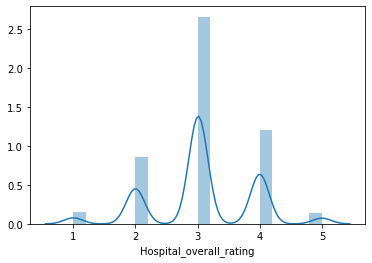

In [84]:
# Distplots for 'Hospital overall rating'
sns.distplot(df['Hospital_overall_rating'],bins=20)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Hospital_overall_rating')]

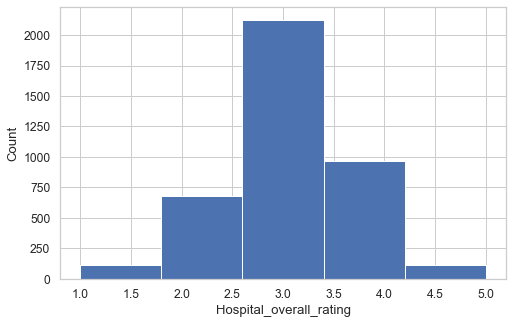

In [85]:
# Distplots for 'Hospital overall rating'
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(df['Hospital_overall_rating'], norm_hist=False, kde=False, bins=5, hist_kws={"alpha": 1}).set(xlabel='Hospital_overall_rating', ylabel='Count')

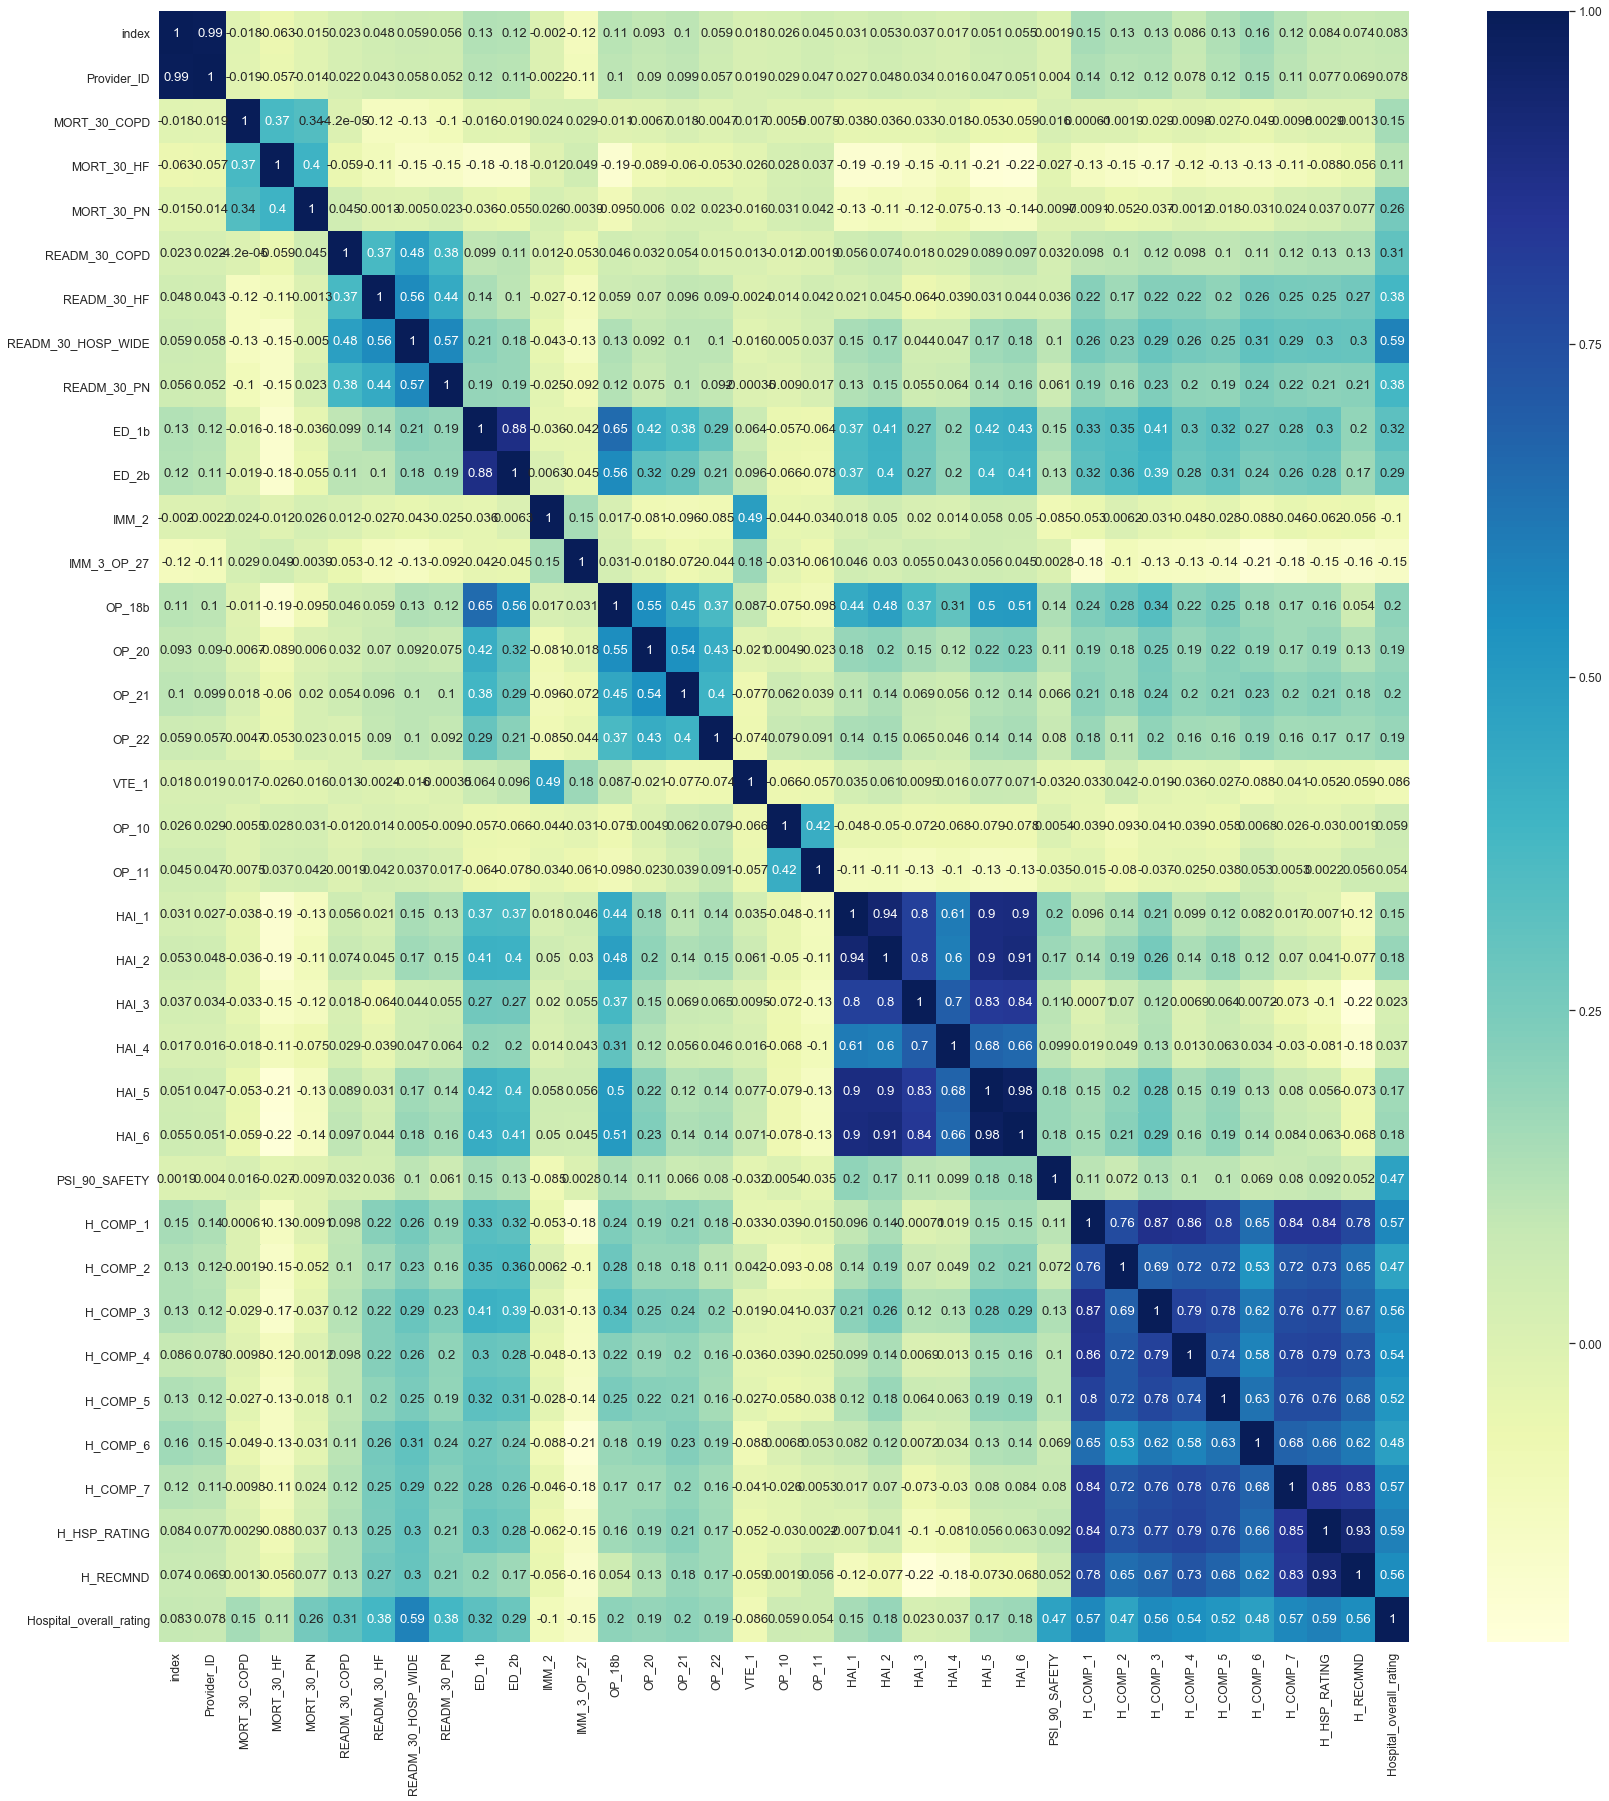

In [86]:
# Let's check the heatmap to see which variables are highly correlated
plt.figure(figsize = (28, 30))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

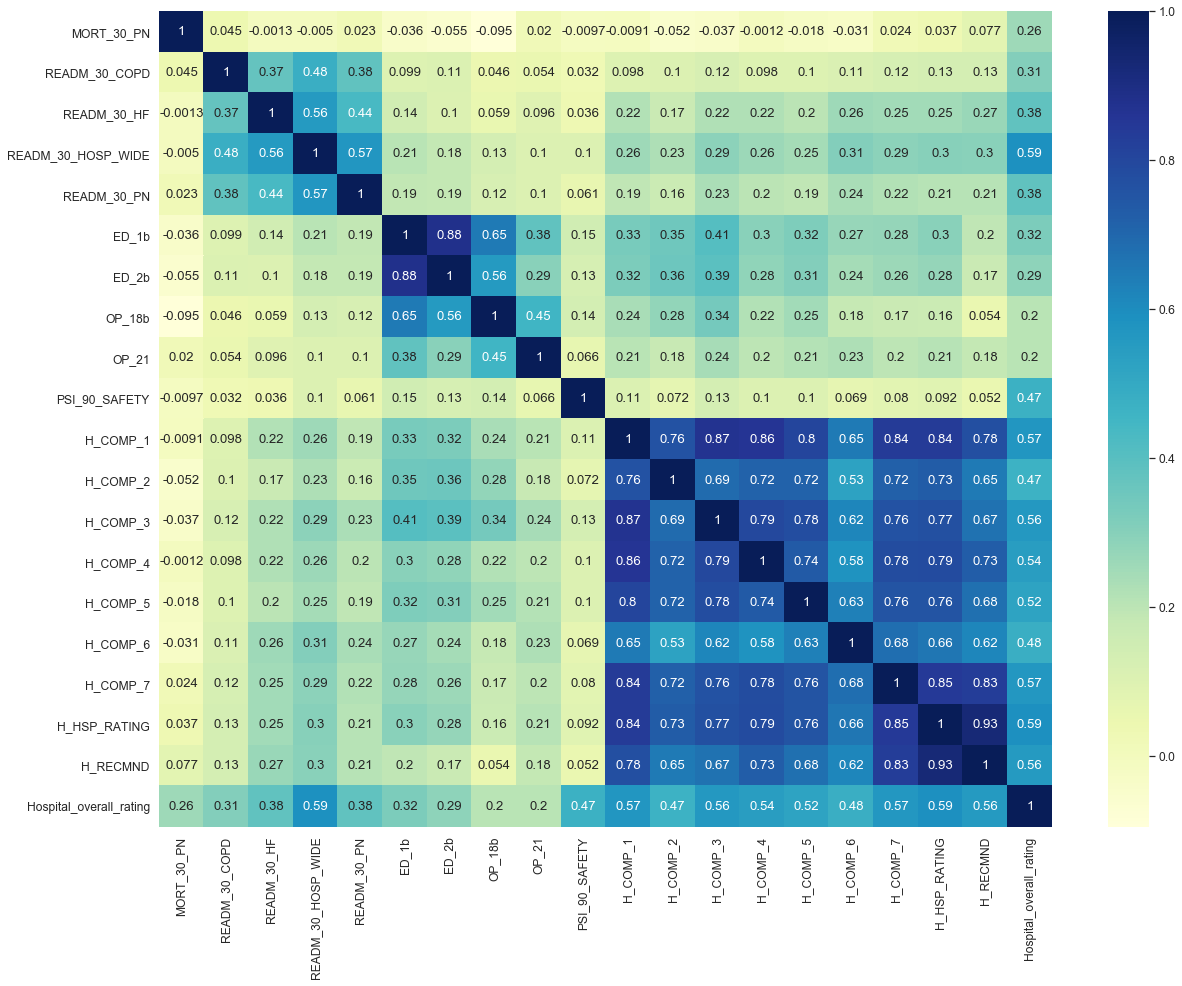

In [87]:
# Since 'Hospital overall rating' is our target variable, let's look at features which show positive correlation with it. 
corr = df.corr()
top = corr.index[abs(corr['Hospital_overall_rating']>0.20)]
plt.subplots(figsize=(20, 15))
top_corr = df[top].corr()
sns.heatmap(top_corr,cmap="YlGnBu", annot=True)
plt.show()

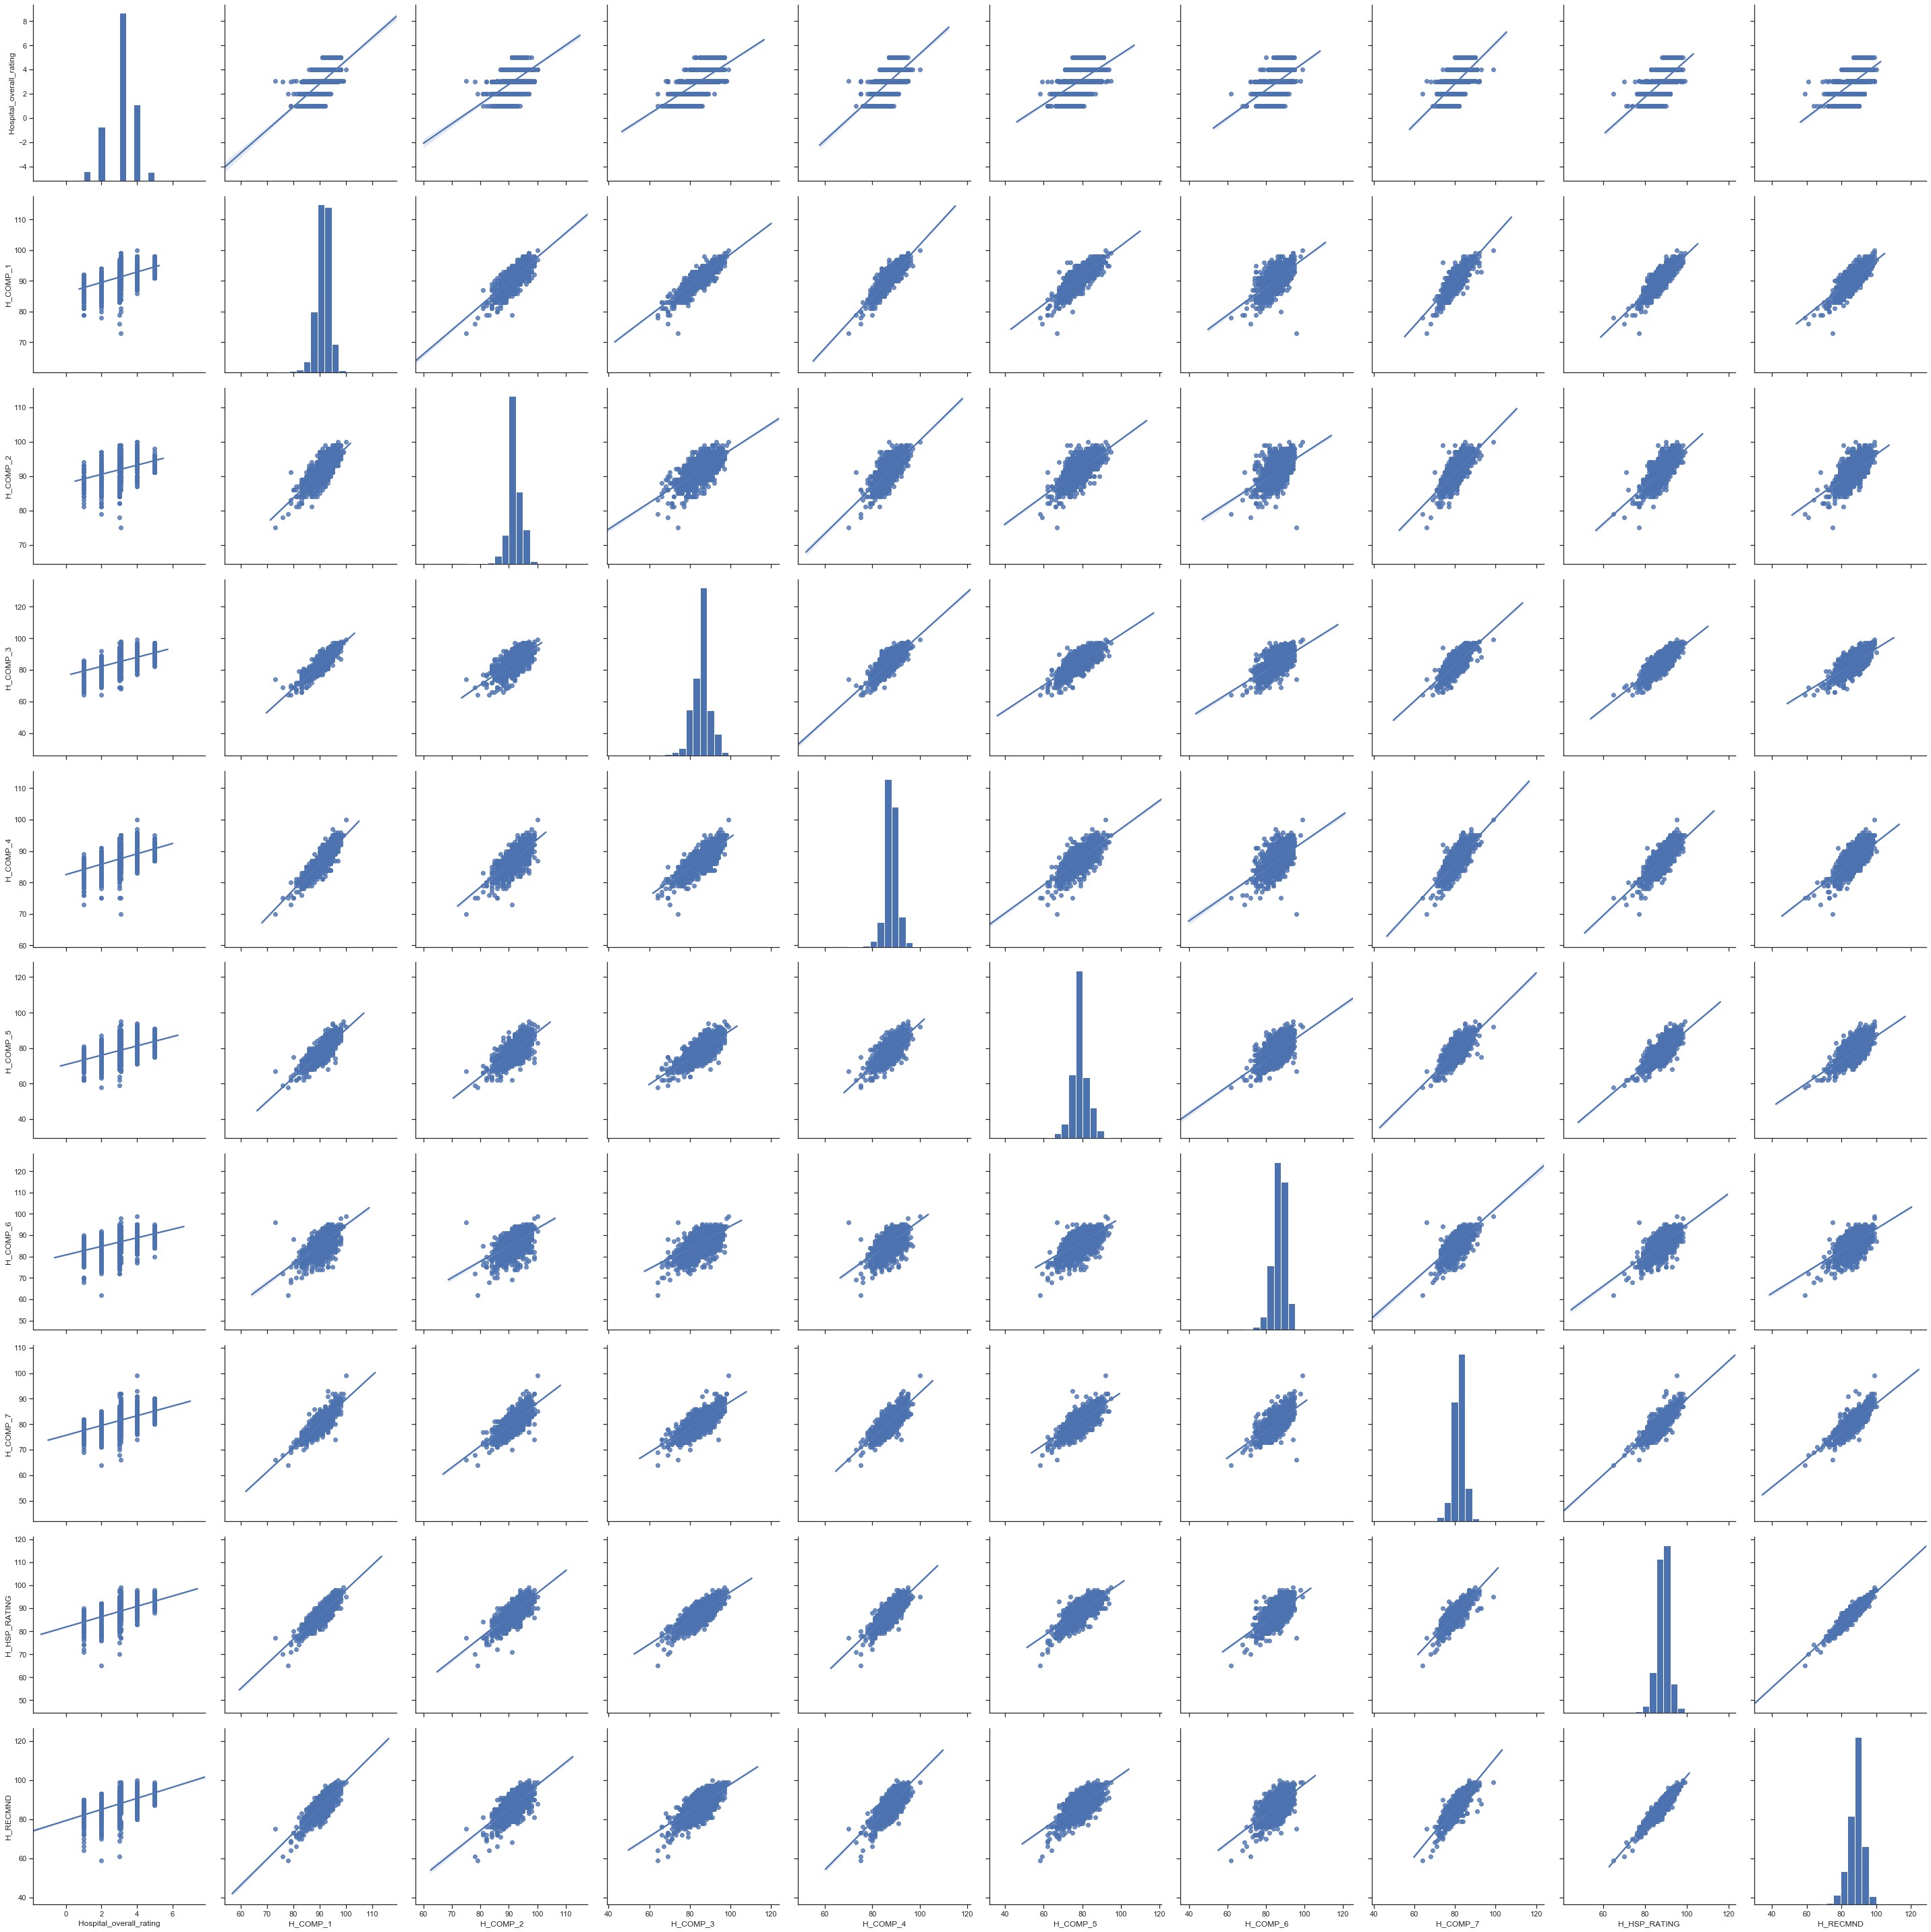

In [88]:
# Visualising all the highly correlated numeric variables using "pair-plots" 
col = ['Hospital_overall_rating', 'H_COMP_1','H_COMP_2','H_COMP_3','H_COMP_4','H_COMP_5','H_COMP_6','H_COMP_7',
'H_HSP_RATING','H_RECMND']
sns.set(style='ticks')
sns.pairplot(df[col], size=4, kind='reg')

**We will plot histograms for features with high correlations.**

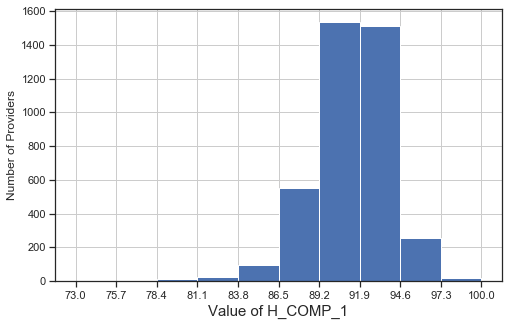

In [89]:
# Histogram for 'H_COMP_1'
count,bin_edges = np.histogram(df['H_COMP_1'])
df['H_COMP_1'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_1', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

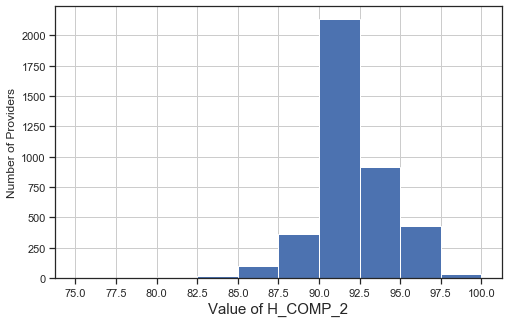

In [90]:
# Histogram for 'H_COMP_2'
count,bin_edges = np.histogram(df['H_COMP_2'])
df['H_COMP_2'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_2', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

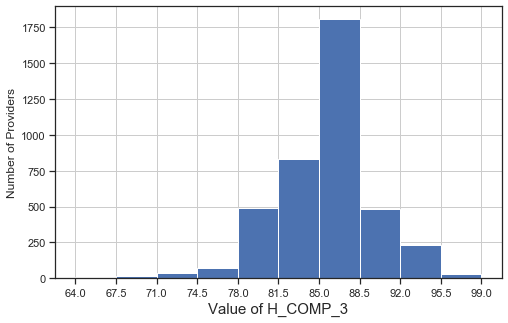

In [91]:
# Histogram for 'H_COMP_3'
count,bin_edges = np.histogram(df['H_COMP_3'])
df['H_COMP_3'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_3', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

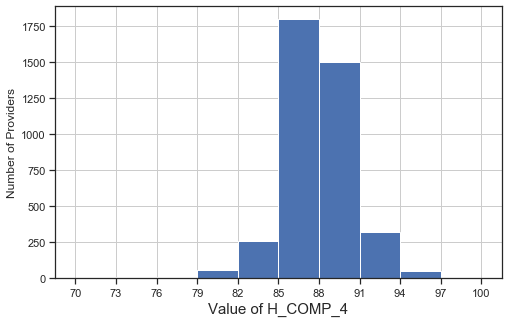

In [92]:
# Histogram for 'H_COMP_4'
count,bin_edges = np.histogram(df['H_COMP_4'])
df['H_COMP_4'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_4', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

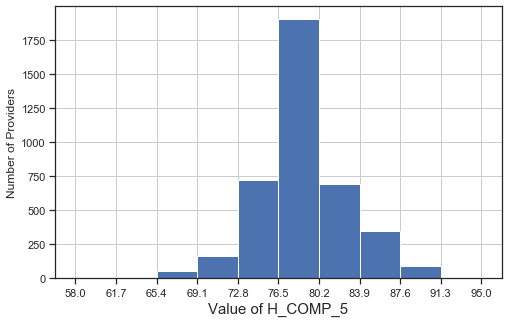

In [93]:
# Histogram for 'H_COMP_5'
count,bin_edges = np.histogram(df['H_COMP_5'])
df['H_COMP_5'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_5', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

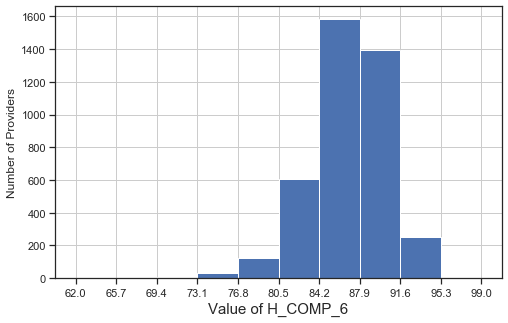

In [94]:
# Histogram for 'H_COMP_6'
count,bin_edges = np.histogram(df['H_COMP_6'])
df['H_COMP_6'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_6', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

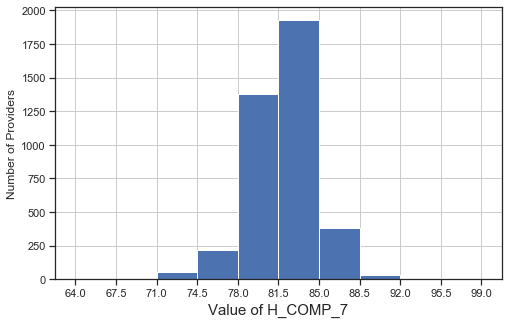

In [95]:
# Histogram for 'H_COMP_7'
count,bin_edges = np.histogram(df['H_COMP_7'])
df['H_COMP_7'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_COMP_7', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

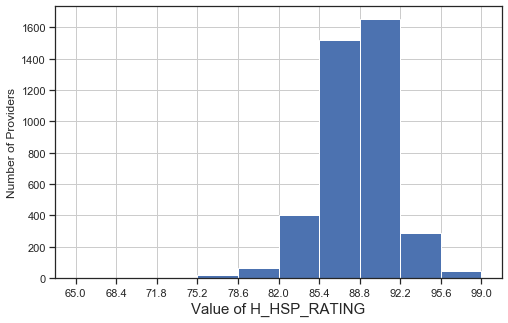

In [96]:
# Histogram for 'H_HSP_RATING'
count,bin_edges = np.histogram(df['H_HSP_RATING'])
df['H_HSP_RATING'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_HSP_RATING', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

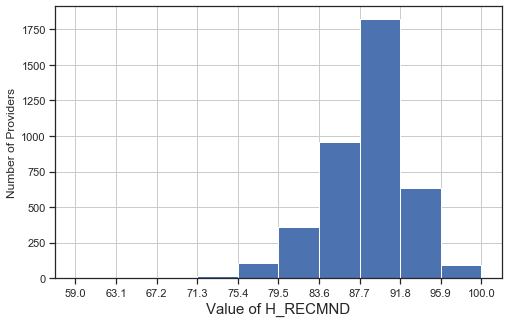

In [97]:
# Histogram for 'H_RECMND'
count,bin_edges = np.histogram(df['H_RECMND'])
df['H_RECMND'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('Value of H_RECMND', fontsize=15)
plt.ylabel('Number of Providers')
plt.grid()
plt.show()

### MODEL BUILDING: 

In [98]:
# Importing StandardScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [99]:
# Dropping 'Provider_ID', 'index'
df1 = df.drop('Provider_ID',axis=1)
df1.drop('index',axis=1,inplace=True)

In [100]:
# Checking the dataframe 'df1'
df1.head()

,MORT_30_COPD,MORT_30_HF,MORT_30_PN,READM_30_COPD,READM_30_HF,READM_30_HOSP_WIDE,READM_30_PN,ED_1b,ED_2b,IMM_2,...,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_4,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_RECMND,Hospital_overall_rating
0,-9.3,-12.4,-15.5,-21.1,-21.4,-15.4,-18.7,-269.0,-68.0,-97.0,...,90.000000,92.000000,80.000000,86.000000,77.000000,87.000000,82.000000,89.000000,90.00000,3.0
1,-7.6,-15.5,-20.8,-18.0,-21.9,-14.9,-16.4,-243.0,-71.0,-99.0,...,91.000000,94.000000,84.000000,88.000000,80.000000,88.000000,81.000000,90.000000,89.00000,3.0
2,-7.1,-15.6,-18.2,-19.8,-20.6,-15.4,-17.9,-217.0,-78.0,-100.0,...,91.000000,94.000000,83.000000,87.000000,78.000000,83.000000,80.000000,85.000000,84.00000,2.0
3,-9.3,-14.4,-18.8,-19.9,-21.1,-16.6,-17.3,-219.0,-68.0,-99.0,...,91.000000,96.000000,87.000000,89.000000,82.000000,86.000000,82.000000,87.000000,86.00000,3.0
4,-8.2,-12.7,-15.7,-19.2,-23.1,-15.7,-16.0,-180.0,-56.0,-95.0,...,91.326205,91.898774,85.273738,87.568007,78.777873,86.901055,81.524665,88.723981,88.03051,3.0


In [101]:
# List of column names retained 
col_names = list(df1.columns)
col_names

['MORT_30_COPD',
 'MORT_30_HF',
 'MORT_30_PN',
 'READM_30_COPD',
 'READM_30_HF',
 'READM_30_HOSP_WIDE',
 'READM_30_PN',
 'ED_1b',
 'ED_2b',
 'IMM_2',
 'IMM_3_OP_27',
 'OP_18b',
 'OP_20',
 'OP_21',
 'OP_22',
 'VTE_1',
 'OP_10',
 'OP_11',
 'HAI_1',
 'HAI_2',
 'HAI_3',
 'HAI_4',
 'HAI_5',
 'HAI_6',
 'PSI_90_SAFETY',
 'H_COMP_1',
 'H_COMP_2',
 'H_COMP_3',
 'H_COMP_4',
 'H_COMP_5',
 'H_COMP_6',
 'H_COMP_7',
 'H_HSP_RATING',
 'H_RECMND',
 'Hospital_overall_rating']

In [102]:
# Applying StandardScaler to feature columns
features = df1[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [103]:
# Assigning features as column names after scaling 
df[col_names] = features
df.head()

,index,Provider_ID,MORT_30_COPD,MORT_30_HF,MORT_30_PN,READM_30_COPD,READM_30_HF,READM_30_HOSP_WIDE,READM_30_PN,ED_1b,...,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_4,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_RECMND,Hospital_overall_rating
0,0,10001,-1.160394,-0.179907,0.434397,-0.919968,0.386176,0.203329,-1.110407,0.108348,...,-0.558704,0.044232,-1.281001,-0.647237,-4.429888e-01,2.968936e-02,0.176861,0.090633,0.481283,-0.092579
1,1,10005,0.460065,-2.423666,-2.148201,1.663913,0.034364,0.792214,0.510809,0.388856,...,-0.137424,0.918154,-0.309393,0.178317,3.045148e-01,3.297487e-01,-0.195216,0.418990,0.236914,-0.092579
2,2,10006,0.936670,-2.496045,-0.881266,0.163595,0.949075,0.203329,-0.546506,0.669363,...,-0.137424,0.918154,-0.552295,-0.234460,-1.938209e-01,-1.170548e+00,-0.567293,-1.222796,-0.984934,-1.347386
3,3,10007,-1.160394,-1.627493,-1.173636,0.080244,0.597263,-1.209994,-0.123580,0.647785,...,-0.137424,1.792076,0.419312,0.591094,8.028506e-01,-2.703699e-01,0.176861,-0.566082,-0.496195,-0.092579
4,4,10008,-0.111862,-0.397045,0.336940,0.663701,-0.809984,-0.150001,0.792760,1.068547,...,0.000000,0.000000,0.000000,0.000000,7.081777e-15,-4.264099e-15,0.000000,0.000000,0.000000,-0.092579


#### Spliting the data into train and test:

In [104]:
# Dropping columns 'Provider ID' and 'index'
df.drop('Provider_ID',axis=1,inplace=True)
df.drop('index',axis=1,inplace=True)

In [105]:
from sklearn.model_selection import train_test_split

#We specify this so that the train and test data set always have the same rows, respectively

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [106]:
# Checking 'df_train'
df_train.head()

,MORT_30_COPD,MORT_30_HF,MORT_30_PN,READM_30_COPD,READM_30_HF,READM_30_HOSP_WIDE,READM_30_PN,ED_1b,ED_2b,IMM_2,...,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_4,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_RECMND,Hospital_overall_rating
2954,0.174102,1.267679,0.483125,8.304026e-01,0.667625,-2.034432,-0.969432,-2.944867,-2.560112,0.030065,...,0.705137,0.044232,0.176410,0.178317,5.534696e-02,3.297487e-01,0.921016,0.747348,1.214392,-0.092579
2653,-1.255715,-1.337976,0.434397,-5.922444e-15,0.386176,0.203329,1.215686,1.435364,1.189923,0.000000,...,0.705137,1.355115,1.390920,0.178317,3.045148e-01,3.297487e-01,0.921016,1.075705,0.481283,1.162228
1305,2.080523,1.919093,0.970408,1.635947e-01,0.175089,0.674437,-0.335043,-0.247681,-0.356144,-0.270282,...,1.126418,-0.392729,0.419312,1.416648,5.536827e-01,3.297487e-01,0.921016,1.075705,0.481283,2.417035
4032,0.746028,2.208610,1.555147,9.971046e-01,0.949075,1.145545,1.920562,-1.078414,-0.849570,-0.570629,...,0.283857,-0.392729,-0.066492,0.591094,5.534696e-02,-2.703699e-01,0.176861,0.418990,0.725653,2.417035
4719,-0.207183,-0.252287,-0.929995,5.803496e-01,-0.739622,0.085552,-0.405531,0.885138,0.992553,-0.370397,...,0.000000,0.000000,0.000000,0.000000,7.081777e-15,-4.264099e-15,0.000000,0.000000,0.000000,-0.092579


In [107]:
# Describing 'df_train'
df_train.describe()

,MORT_30_COPD,MORT_30_HF,MORT_30_PN,READM_30_COPD,READM_30_HF,READM_30_HOSP_WIDE,READM_30_PN,ED_1b,ED_2b,IMM_2,...,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_4,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_RECMND,Hospital_overall_rating
count,2.798000e+03,2.798000e+03,2.798000e+03,2.798000e+03,2.798000e+03,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,...,2798.000000,2798.000000,2798.000000,2798.000000,2.798000e+03,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000
mean,-1.913461e-02,-2.412589e-02,-1.214318e-02,-1.175591e-02,1.124988e-02,0.000013,0.000066,0.017367,0.010945,-0.005243,...,0.012215,-0.001577,0.010124,0.006631,1.780103e-03,0.002822,0.005731,0.000349,0.000286,0.001184
std,9.941101e-01,9.878660e-01,1.006610e+00,1.015369e+00,9.920832e-01,0.987883,0.998509,0.986165,0.987255,0.978790,...,0.999123,1.008357,0.989493,0.995797,9.948649e-01,0.990873,0.995697,0.996183,1.003915,0.998400
min,-5.735805e+00,-4.088390e+00,-5.071897e+00,-5.087518e+00,-6.579699e+00,-4.507747,-5.339667,-8.166620,-8.152271,-0.670744,...,-7.720474,-7.384106,-5.167430,-7.251669,-5.177179e+00,-7.471793,-6.520530,-7.789944,-7.094171,-2.602193
25%,-4.931460e-01,-6.141831e-01,-5.888968e-01,-5.032132e-01,-5.285350e-01,-0.503332,-0.546506,-0.312413,-0.290354,-0.570629,...,-0.558704,-0.392729,-0.552295,-0.647237,-4.429888e-01,-0.570429,-0.567293,-0.566082,-0.496195,-0.092579
50%,-1.015946e-14,-2.571430e-15,6.924703e-15,-5.922444e-15,-1.749841e-14,0.085552,0.017395,0.086771,0.104387,-0.270282,...,0.000000,0.044232,0.000000,0.000000,7.081777e-15,0.029689,0.000000,0.000000,0.000000,-0.092579
75%,5.553859e-01,5.438859e-01,6.293098e-01,5.803496e-01,5.972629e-01,0.556660,0.651784,0.626208,0.647155,0.030065,...,0.705137,0.481193,0.662214,0.591094,5.536827e-01,0.629808,0.548939,0.418990,0.725653,1.162228
max,3.319697e+00,4.018093e+00,3.747919e+00,3.414283e+00,3.833932e+00,5.621068,2.977877,2.276886,1.683349,9.340812,...,3.654101,3.539921,3.334134,5.131641,3.543697e+00,3.630401,6.502176,3.045849,2.924978,2.417035


#### Dividing X and Y in sets for model building:

In [108]:
y_train = df_train.pop('Hospital_overall_rating')
X_train = df_train

## LINEAR REGRESSION:

#### Making use of RFE ( Recursive feature elimination):

In [109]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#### Selecting the top 20 varibales for performing RFE:

In [110]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [111]:
# Importing eli5 library to obtain weights of features
import eli5

# Checking feature weights using eli5
eli5.show_weights(lm, feature_names = ['MORT_30_COPD','MORT_30_HF','MORT_30_PN','READM_30_COPD','READM_30_HF','READM_30_HOSP_WIDE',
'READM_30_PN','ED_1b','ED_2b','IMM_2','IMM_3_OP_27','OP_18b','OP_20','OP_21','OP_22','VTE_1','OP_10','OP_11','HAI_1','HAI_2',
'HAI_3','HAI_4','HAI_5','HAI_6','PSI_90_SAFETY','H_COMP_1','H_COMP_2','H_COMP_3','H_COMP_4','H_COMP_5','H_COMP_6','H_COMP_7',
'H_HSP_RATING','H_RECMND'])

Weight?,Feature
+0.376,PSI_90_SAFETY
+0.371,READM_30_HOSP_WIDE
+0.171,MORT_30_PN
+0.156,MORT_30_HF
+0.106,H_HSP_RATING
+0.102,MORT_30_COPD
+0.081,H_COMP_3
+0.071,H_COMP_7
+0.060,HAI_2
+0.051,READM_30_HF


In [112]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MORT_30_COPD', True, 1),
 ('MORT_30_HF', True, 1),
 ('MORT_30_PN', True, 1),
 ('READM_30_COPD', False, 2),
 ('READM_30_HF', True, 1),
 ('READM_30_HOSP_WIDE', True, 1),
 ('READM_30_PN', False, 3),
 ('ED_1b', True, 1),
 ('ED_2b', False, 13),
 ('IMM_2', False, 6),
 ('IMM_3_OP_27', False, 12),
 ('OP_18b', False, 11),
 ('OP_20', False, 10),
 ('OP_21', False, 15),
 ('OP_22', False, 9),
 ('VTE_1', True, 1),
 ('OP_10', True, 1),
 ('OP_11', False, 8),
 ('HAI_1', True, 1),
 ('HAI_2', True, 1),
 ('HAI_3', False, 7),
 ('HAI_4', False, 14),
 ('HAI_5', True, 1),
 ('HAI_6', True, 1),
 ('PSI_90_SAFETY', True, 1),
 ('H_COMP_1', True, 1),
 ('H_COMP_2', False, 5),
 ('H_COMP_3', True, 1),
 ('H_COMP_4', True, 1),
 ('H_COMP_5', True, 1),
 ('H_COMP_6', True, 1),
 ('H_COMP_7', True, 1),
 ('H_HSP_RATING', True, 1),
 ('H_RECMND', False, 4)]

In [113]:
# CoLumns selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['MORT_30_COPD', 'MORT_30_HF', 'MORT_30_PN', 'READM_30_HF',
       'READM_30_HOSP_WIDE', 'ED_1b', 'VTE_1', 'OP_10', 'HAI_1', 'HAI_2',
       'HAI_5', 'HAI_6', 'PSI_90_SAFETY', 'H_COMP_1', 'H_COMP_3', 'H_COMP_4',
       'H_COMP_5', 'H_COMP_6', 'H_COMP_7', 'H_HSP_RATING'],
      dtype='object')

In [114]:
# CoLumns rejected by RFE
X_train.columns[~rfe.support_]

Index(['READM_30_COPD', 'READM_30_PN', 'ED_2b', 'IMM_2', 'IMM_3_OP_27',
       'OP_18b', 'OP_20', 'OP_21', 'OP_22', 'OP_11', 'HAI_3', 'HAI_4',
       'H_COMP_2', 'H_RECMND'],
      dtype='object')

In [115]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [116]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [117]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [118]:
# The summary of our linear model
print(lm.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital_overall_rating   R-squared:                       0.804
Model:                                 OLS   Adj. R-squared:                  0.803
Method:                      Least Squares   F-statistic:                     570.8
Date:                     Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                             23:25:51   Log-Likelihood:                -1682.9
No. Observations:                     2798   AIC:                             3408.
Df Residuals:                         2777   BIC:                             3533.
Df Model:                               20                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [119]:
# Dropping constant to check the vif value
X_train_new = X_train_rfe.drop(["const"], axis = 1)

In [120]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,HAI_6,26.61
10,HAI_5,24.14
9,HAI_2,10.35
8,HAI_1,10.04
13,H_COMP_1,7.96
14,H_COMP_3,5.12
18,H_COMP_7,4.90
19,H_HSP_RATING,4.88
15,H_COMP_4,4.21
16,H_COMP_5,3.55


#### Dropping the column 'HAI_6' as it has high p value and vif value.

In [121]:
# Dropping 'HAI_6'
X_train_1 = X_train_rfe.drop(['HAI_6'], axis = 1)

In [122]:
# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_1)

In [123]:
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()   

In [124]:
# Summary of linear model
print(lm.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital_overall_rating   R-squared:                       0.804
Model:                                 OLS   Adj. R-squared:                  0.803
Method:                      Least Squares   F-statistic:                     600.8
Date:                     Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                             23:25:52   Log-Likelihood:                -1683.4
No. Observations:                     2798   AIC:                             3407.
Df Residuals:                         2778   BIC:                             3526.
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [125]:
# Dropping 'const'
X_train_2 = X_train_1.drop(["const"], axis = 1)

In [126]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,HAI_1,10.02
9,HAI_2,9.82
12,H_COMP_1,7.91
10,HAI_5,6.55
13,H_COMP_3,5.11
17,H_COMP_7,4.90
18,H_HSP_RATING,4.87
14,H_COMP_4,4.21
15,H_COMP_5,3.54
16,H_COMP_6,2.13


#### Dropping the column 'HAI_1' as it has high p value and vif value.

In [127]:
# Dropping column 'HAI_1'
X_train_2 = X_train_1.drop(['HAI_1'], axis = 1)

In [128]:
# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_2)

In [129]:
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()   

In [130]:
# Summary of linear model
print(lm.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital_overall_rating   R-squared:                       0.804
Model:                                 OLS   Adj. R-squared:                  0.803
Method:                      Least Squares   F-statistic:                     633.8
Date:                     Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                             23:25:53   Log-Likelihood:                -1684.5
No. Observations:                     2798   AIC:                             3407.
Df Residuals:                         2779   BIC:                             3520.
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [131]:
# Dropping 'const'
X_train_3 = X_train_2.drop(["const"], axis = 1)

In [132]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,H_COMP_1,7.90
9,HAI_5,5.56
8,HAI_2,5.34
12,H_COMP_3,5.10
16,H_COMP_7,4.88
17,H_HSP_RATING,4.87
13,H_COMP_4,4.21
14,H_COMP_5,3.53
15,H_COMP_6,2.13
4,READM_30_HOSP_WIDE,1.57


#### Dropping the column 'H_COMP_1' as it has high vif value.

In [133]:
# Dropping column 'H_COMP_1'
X_train_3 = X_train_2.drop('H_COMP_1', axis = 1)

In [134]:
# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_3)

In [135]:
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()   

In [136]:
# Summary of linear model
print(lm.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital_overall_rating   R-squared:                       0.804
Model:                                 OLS   Adj. R-squared:                  0.802
Method:                      Least Squares   F-statistic:                     669.5
Date:                     Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                             23:25:54   Log-Likelihood:                -1687.5
No. Observations:                     2798   AIC:                             3411.
Df Residuals:                         2780   BIC:                             3518.
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [137]:
# Dropping 'const'
X_train_4 = X_train_3.drop(["const"], axis = 1)

In [138]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_4
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,HAI_5,5.55
8,HAI_2,5.34
15,H_COMP_7,4.69
16,H_HSP_RATING,4.69
11,H_COMP_3,4.23
12,H_COMP_4,3.61
13,H_COMP_5,3.43
14,H_COMP_6,2.13
4,READM_30_HOSP_WIDE,1.56
3,READM_30_HF,1.46


#### Dropping the column 'HAI_5' as it has high and vif value.

In [139]:
# Dropping column 'HAI_5'
X_train_4 = X_train_3.drop('HAI_5', axis = 1)

In [140]:
# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_4)

In [141]:
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()   

In [142]:
# Summary of linear model
print(lm.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital_overall_rating   R-squared:                       0.803
Model:                                 OLS   Adj. R-squared:                  0.802
Method:                      Least Squares   F-statistic:                     708.2
Date:                     Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                             23:25:54   Log-Likelihood:                -1692.8
No. Observations:                     2798   AIC:                             3420.
Df Residuals:                         2781   BIC:                             3521.
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [143]:
# Dropping 'const'
X_train_5 = X_train_4.drop(["const"], axis = 1)

In [144]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_5
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
14,H_COMP_7,4.69
15,H_HSP_RATING,4.67
10,H_COMP_3,4.19
11,H_COMP_4,3.61
12,H_COMP_5,3.43
13,H_COMP_6,2.13
4,READM_30_HOSP_WIDE,1.56
3,READM_30_HF,1.46
5,ED_1b,1.43
8,HAI_2,1.39


**p-value and VIF of all the features are within limits and r-squared/ adjusted r-squared is constant as well for this model.** 

**We can proceed with residual analysis.**

**Residual analysis of TRAIN DATA:** 

So, now to check if the error terms are also normally distributed, the histogram will be plotted of the error terms and see what it looks like.

In [145]:
# Running trained model
y_train_rating = lm.predict(X_train_lm)

In [146]:
# Importing the required libraries for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

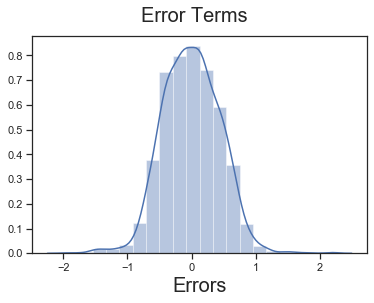

In [147]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_rating), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 20)                         # X-label

### MAKING PREDICTIONS:
Dividing into X_test and y_test:

In [148]:
# Dividing data
y_test = df_test.pop('Hospital_overall_rating')
X_test = df_test

In [149]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_5.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [150]:
# Making predictions
y_pred = lm.predict(X_test_new)

MODEL EVALUATION

Text(0, 0.5, 'y_pred')

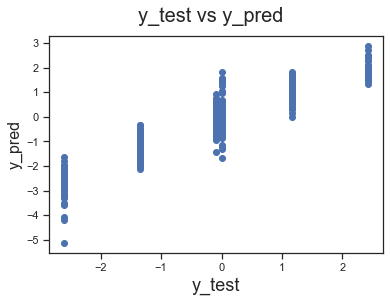

In [151]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

**TRAIN SET:**

R-squared score: 0.803

Adjusted R-squared score: 0.802

In [152]:
# Calculating the R-squared score on the test set:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8115637209713389

**VARIABLES SIGNIFICANT IN PREDICTING THE HOSPITAL RATING:**
1. 'MORT_30_COPD'
2. 'MORT_30_HF'
3. 'MORT_30_PN'
4. 'READM_30_HF'
5. 'READM_30_HOSP_WIDE'
6. 'ED_1b'
7. 'VTE_1'
8. 'OP_10'
9. 'HAI_2'
10. 'PSI_90_SAFETY'
11. 'H_COMP_3'
12. 'H_COMP_4'
13. 'H_COMP_5'
14. 'H_COMP_6'
15. 'H_COMP_7'
16. 'H_HSP_RATING'

**EQUATION OF THE BEST FITTED LINE IS:**

HOSPITAL RATING = (-0.1052 * MORT_30_COPD) + (-0.1551 * MORT_30_HF) + (-0.1721 * MORT_30_PN) +  (-0.0636 * READM_30_HF) +  (-0.3964 * READM_30_HOSP_WIDE) + (-0.0526 * ED_1b) + (0.0380 * VTE_1) + (-0.0562 * OP_10) + (-0.0355 * HAI_2) + (-0.3769 * PSI_90_SAFETY) + (0.0886 * H_COMP_3) + (0.0650 * H_COMP_4) + (0.0561 * H_COMP_5) +  (0.0344 * H_COMP_6) +  (0.0914 * H_COMP_7) + (0.1480 * H_HSP_RATING)

## RANDOM FOREST:

In [153]:
# Importing random forest regressor from sklearn library
from sklearn.ensemble import RandomForestRegressor

# Running the random forest with default parameters.
rfr = RandomForestRegressor()

In [154]:
# fit
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [155]:
# Checking the weights of the features using eli5
eli5.show_weights(rfr, feature_names = ['MORT_30_COPD','MORT_30_HF','MORT_30_PN','READM_30_COPD','READM_30_HF','READM_30_HOSP_WIDE',
'READM_30_PN','ED_1b','ED_2b','IMM_2','IMM_3_OP_27','OP_18b','OP_20','OP_21','OP_22','VTE_1','OP_10','OP_11','HAI_1','HAI_2',
'HAI_3','HAI_4','HAI_5','HAI_6','PSI_90_SAFETY','H_COMP_1','H_COMP_2','H_COMP_3','H_COMP_4','H_COMP_5','H_COMP_6','H_COMP_7',
'H_HSP_RATING','H_RECMND'])

Weight,Feature
0.2291 ± 0.0788,READM_30_HOSP_WIDE
0.1699 ± 0.0269,PSI_90_SAFETY
0.1380 ± 0.2155,H_HSP_RATING
0.0752 ± 0.1418,H_COMP_7
0.0499 ± 0.0138,MORT_30_PN
0.0461 ± 0.1244,H_COMP_1
0.0398 ± 0.1298,H_COMP_4
0.0324 ± 0.0086,MORT_30_HF
0.0257 ± 0.0545,H_RECMND
0.0208 ± 0.0125,MORT_30_COPD


In [156]:
# Making predictions
predictions = rfr.predict(X_test)

In [157]:
# Accuracy of model
rfr.score(X_test, y_test)

0.7708851128730441

#### Tuning max_depth:

In [158]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(5, 20, 5)}

# instantiate the model
rf = RandomForestRegressor()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                    return_train_score = True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(5, 20, 5)},
             

In [159]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.177,0.014089,0.0040,0.001225,5,{'max_depth': 5},0.713466,0.673214,0.659664,0.659511,...,0.676798,0.019760,3,0.749280,0.747077,0.750538,0.750629,0.759799,0.751465,0.004360
1,0.306,0.005148,0.0035,0.001225,10,{'max_depth': 10},0.768880,0.750763,0.707715,0.745693,...,0.739088,0.021598,2,0.927147,0.925262,0.925478,0.926532,0.932121,0.927308,0.002503
2,0.356,0.002550,0.0045,0.001000,15,{'max_depth': 15},0.774459,0.746013,0.723998,0.729694,...,0.741602,0.017957,1,0.943476,0.946505,0.946235,0.949000,0.949564,0.946956,0.002182


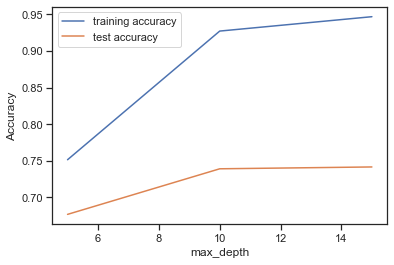

In [160]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that with increase in the value of max_depth, both train and test scores increase till a point, but after that test score stays more or less constant. The model tries to overfit as we increase the max_depth.

Thus, controlling the depth will help in reducing overfitting in the forest.

#### Tuning n_estimators:

In [161]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(150, 1500, 500)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestRegressor(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                     return_train_score = True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=4, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': range(150, 1500, 500)},
             pre_dispatch='2*n_jobs', r

In [162]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.0550,0.018641,0.0155,0.001000,150,{'n_estimators': 150},0.672680,0.645559,0.631075,0.631099,...,0.645496,0.015212,3,0.688721,0.691193,0.695096,0.699314,0.699905,0.694846,0.004393
1,8.8955,0.063115,0.0565,0.001225,650,{'n_estimators': 650},0.673592,0.646087,0.633097,0.629737,...,0.645983,0.015457,2,0.690884,0.691389,0.696488,0.699939,0.700300,0.695800,0.004037
2,15.7595,0.058168,0.0980,0.001000,1150,{'n_estimators': 1150},0.673210,0.646374,0.633459,0.631988,...,0.646162,0.014795,1,0.690952,0.690632,0.697369,0.700540,0.699393,0.695777,0.004196


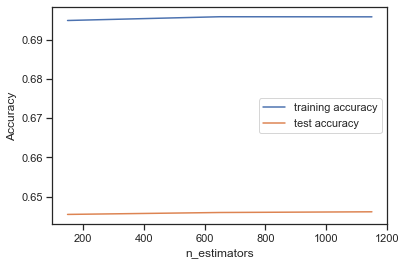

In [163]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Increase in number of n_estimators does not seem to have much effect on the accuracy.

#### Tuning max_faeatures:

In [164]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [2, 10, 14, 25, 30]}

# instantiate the model
rf = RandomForestRegressor(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   return_train_score = True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=4, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [2, 10, 14, 25, 30]},
             pre_dispatch='2*n_jobs', ref

In [165]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.0215,0.002000,0.0045,1.870782e-03,2,{'max_features': 2},0.505396,0.461232,0.471910,0.503057,...,0.496761,0.028521,5,0.516323,0.516443,0.526425,0.571597,0.555238,0.537205,0.022322
1,0.0490,0.001225,0.0025,9.536743e-08,10,{'max_features': 10},0.632135,0.585023,0.590225,0.599780,...,0.606376,0.018770,4,0.637718,0.649859,0.647447,0.647671,0.654565,0.647452,0.005499
2,0.0645,0.001000,0.0030,9.999275e-04,14,{'max_features': 14},0.654703,0.591240,0.603711,0.602903,...,0.616978,0.023224,3,0.659415,0.653793,0.668304,0.668586,0.675704,0.665160,0.007681
3,0.1055,0.001871,0.0030,9.999514e-04,25,{'max_features': 25},0.654402,0.624762,0.622092,0.615570,...,0.627540,0.013765,2,0.669265,0.671899,0.685096,0.687271,0.677510,0.678208,0.007069
4,0.1225,0.001581,0.0035,1.224695e-03,30,{'max_features': 30},0.668368,0.623264,0.627244,0.622356,...,0.631013,0.019193,1,0.679006,0.673258,0.685381,0.686719,0.683836,0.681640,0.004935


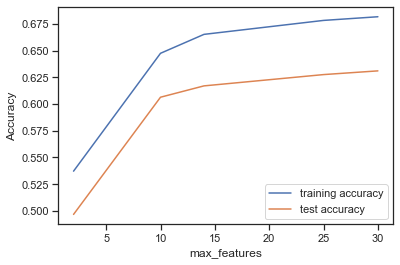

In [166]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The training and test scores both seem to increase as we increase max_features and the model doesn't seem to overfit more with increasing max_features.

#### Tuning min_samples_leaf:

In [167]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(150, 400, 50)}

# instantiate the model
rf = RandomForestRegressor()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   return_train_score = True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(150, 

In [168]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.1045,4.301012e-03,0.0040,1.224695e-03,150,{'min_samples_leaf': 150},0.566654,0.525485,0.501358,0.504879,...,0.528228,0.024343,1,0.552820,0.556066,0.548535,0.544791,0.554062,0.551255,0.004066
1,0.0895,5.787894e-03,0.0010,1.224773e-03,200,{'min_samples_leaf': 200},0.524588,0.467180,0.465619,0.478669,...,0.485105,0.021550,2,0.511568,0.507707,0.486171,0.508783,0.500280,0.502902,0.009161
2,0.0810,6.041586e-03,0.0010,1.224773e-03,250,{'min_samples_leaf': 250},0.478075,0.431120,0.433382,0.431829,...,0.445208,0.018108,3,0.460589,0.466512,0.457152,0.480920,0.467450,0.466524,0.008138
3,0.0690,4.062142e-03,0.0025,1.507891e-07,300,{'min_samples_leaf': 300},0.448071,0.408449,0.412428,0.412879,...,0.418117,0.015095,4,0.434160,0.442838,0.434700,0.441847,0.419703,0.434650,0.008276
4,0.0600,1.168008e-07,0.0035,1.224656e-03,350,{'min_samples_leaf': 350},0.394872,0.374242,0.386355,0.387526,...,0.394938,0.019549,5,0.389094,0.408329,0.417399,0.421241,0.420176,0.411248,0.011972


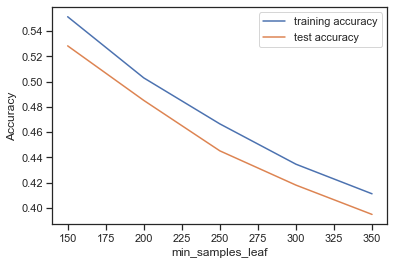

In [169]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that with increase in the value of min_samples_leaf, both train and test scores decrease. The model starts to overfit as we decrease the value of min_samples_leaf. 

#### Tuning min_samples_split:

In [170]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(150, 500, 100)}

# instantiate the model
rf = RandomForestRegressor()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   return_train_score = True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(150,

In [171]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.2000,0.009354,0.0035,1.224695e-03,150,{'min_samples_split': 150},0.675268,0.644536,0.627407,0.644814,...,0.646066,0.015913,1,0.698628,0.696530,0.700668,0.703158,0.705819,0.700961,0.003274
1,0.1440,0.005148,0.0035,1.224773e-03,250,{'min_samples_split': 250},0.624007,0.607438,0.568063,0.569832,...,0.592413,0.021576,2,0.625145,0.652288,0.626625,0.622746,0.640204,0.633401,0.011230
2,0.1230,0.013910,0.0025,9.536743e-08,350,{'min_samples_split': 350},0.569281,0.541716,0.534303,0.558836,...,0.556989,0.017158,3,0.556798,0.577923,0.593201,0.599859,0.610270,0.587610,0.018644
3,0.1085,0.011247,0.0025,1.784161e-07,450,{'min_samples_split': 450},0.540449,0.517180,0.506786,0.479203,...,0.518361,0.024670,4,0.531039,0.563076,0.545214,0.524560,0.557928,0.544364,0.014863


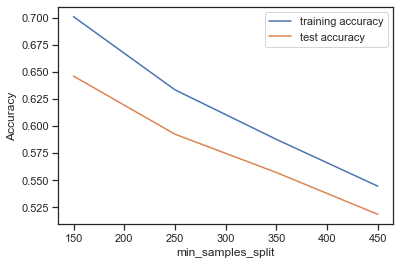

In [172]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that with increase in the value of min_samples_split, both train and test scores decrease. The model starts to overfit as we decrease the value of min_samples_split. Higher accuracy is seen for lower values of min_samples_split.  

#### Grid Search to Find Optimal Hyperparameters:

In [173]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,10,15],
    'min_samples_leaf': range(50, 300, 200),
    'min_samples_split': range(50, 500, 200),
    'n_estimators': [100, 200, 300], 
    'max_features': [10, 20]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [174]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [4, 10, 15], 'max_fe

In [175]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.6507100460017438 using {'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 200}


In [176]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf= 50, 
                             min_samples_split= 50,
                             max_features=20,
                             n_estimators=300)

In [177]:
# fit
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [178]:
# predict
predictions = rfr.predict(X_test)

In [179]:
# Accuracy of model
rfr.score(X_test, y_test)

0.6949338559095648

### UNSUPERVISED ANALYSIS:

### CLUSTERING MODELS:

In [180]:
# Importing necessory libraries
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

In [181]:
# Recalling df_inter from above and imputing the missing values with mean values of the column
df_inter = df_inter.fillna(df_inter.mean())
df_inter.head()

,index,Provider ID,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, READM_30_AMI)","(Score, READM_30_CABG)",...,"(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_QUIET_HSP)","(Score, H_RECMND)",Hospital overall rating
0,0,10001,-12.500000,-4.200000,-9.3,-12.4,-15.5,-15.400000,-16.500000,-15.100000,...,92.000000,80.000000,86.0000,77.000000,87.000000,82.000000,89.000000,NaN,90.000000,3.0
1,1,10005,-16.000000,-3.331599,-7.6,-15.5,-20.8,-15.500000,-16.700000,-14.407108,...,94.000000,84.000000,88.0000,80.000000,88.000000,81.000000,90.000000,NaN,89.000000,3.0
2,2,10006,-16.700000,-4.100000,-7.1,-15.6,-18.2,-17.900000,-16.100000,-15.200000,...,94.000000,83.000000,87.0000,78.000000,83.000000,80.000000,85.000000,NaN,84.000000,2.0
3,3,10007,-14.064363,-3.331599,-9.3,-14.4,-18.8,-16.600000,-16.891586,-14.407108,...,96.000000,87.000000,89.0000,82.000000,86.000000,82.000000,87.000000,NaN,86.000000,3.0
4,4,10008,-14.064363,-3.331599,-8.2,-12.7,-15.7,-14.930717,-16.891586,-14.407108,...,91.899373,85.275086,87.5687,78.780217,86.901653,81.526511,88.726055,NaN,88.032782,3.0


In [182]:
# Dropping columns with all NaN values
df_inter = df_inter.drop([('Score','H_CLEAN_HSP'),('Score','H_QUIET_HSP')], axis=1)

In [183]:
# Dropping columns which are not required for now
df_inter1 = df_inter.drop(['index', 'Provider ID'], axis=1)

In [184]:
# Resetting the index
df_inter1.reset_index(drop = True)
df_inter1.head()

,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, READM_30_AMI)","(Score, READM_30_CABG)","(Score, READM_30_COPD)","(Score, READM_30_HF)",...,"(Score, H_COMP_1)","(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_RECMND)",Hospital overall rating
0,-12.500000,-4.200000,-9.3,-12.4,-15.5,-15.400000,-16.500000,-15.100000,-21.1,-21.4,...,90.000000,92.000000,80.000000,86.0000,77.000000,87.000000,82.000000,89.000000,90.000000,3.0
1,-16.000000,-3.331599,-7.6,-15.5,-20.8,-15.500000,-16.700000,-14.407108,-18.0,-21.9,...,91.000000,94.000000,84.000000,88.0000,80.000000,88.000000,81.000000,90.000000,89.000000,3.0
2,-16.700000,-4.100000,-7.1,-15.6,-18.2,-17.900000,-16.100000,-15.200000,-19.8,-20.6,...,91.000000,94.000000,83.000000,87.0000,78.000000,83.000000,80.000000,85.000000,84.000000,2.0
3,-14.064363,-3.331599,-9.3,-14.4,-18.8,-16.600000,-16.891586,-14.407108,-19.9,-21.1,...,91.000000,96.000000,87.000000,89.0000,82.000000,86.000000,82.000000,87.000000,86.000000,3.0
4,-14.064363,-3.331599,-8.2,-12.7,-15.7,-14.930717,-16.891586,-14.407108,-19.2,-23.1,...,91.327537,91.899373,85.275086,87.5687,78.780217,86.901653,81.526511,88.726055,88.032782,3.0


In [185]:
# Checking the column names and other details
df_inter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 61 columns):
(Score, MORT_30_AMI)           4818 non-null float64
(Score, MORT_30_CABG)          4818 non-null float64
(Score, MORT_30_COPD)          4818 non-null float64
(Score, MORT_30_HF)            4818 non-null float64
(Score, MORT_30_PN)            4818 non-null float64
(Score, MORT_30_STK)           4818 non-null float64
(Score, READM_30_AMI)          4818 non-null float64
(Score, READM_30_CABG)         4818 non-null float64
(Score, READM_30_COPD)         4818 non-null float64
(Score, READM_30_HF)           4818 non-null float64
(Score, READM_30_HIP_KNEE)     4818 non-null float64
(Score, READM_30_HOSP_WIDE)    4818 non-null float64
(Score, READM_30_PN)           4818 non-null float64
(Score, READM_30_STK)          4818 non-null float64
(Score, CAC_3)                 4818 non-null float64
(Score, ED_1b)                 4818 non-null float64
(Score, ED_2b)                 4818 non-null 

In [186]:
# List of column names retained 
col_names = list(df_inter1.columns)
col_names

[('Score', 'MORT_30_AMI'),
 ('Score', 'MORT_30_CABG'),
 ('Score', 'MORT_30_COPD'),
 ('Score', 'MORT_30_HF'),
 ('Score', 'MORT_30_PN'),
 ('Score', 'MORT_30_STK'),
 ('Score', 'READM_30_AMI'),
 ('Score', 'READM_30_CABG'),
 ('Score', 'READM_30_COPD'),
 ('Score', 'READM_30_HF'),
 ('Score', 'READM_30_HIP_KNEE'),
 ('Score', 'READM_30_HOSP_WIDE'),
 ('Score', 'READM_30_PN'),
 ('Score', 'READM_30_STK'),
 ('Score', 'CAC_3'),
 ('Score', 'ED_1b'),
 ('Score', 'ED_2b'),
 ('Score', 'IMM_2'),
 ('Score', 'IMM_3_OP_27'),
 ('Score', 'OP_18b'),
 ('Score', 'OP_20'),
 ('Score', 'OP_21'),
 ('Score', 'OP_22'),
 ('Score', 'OP_23'),
 ('Score', 'OP_3'),
 ('Score', 'OP_4'),
 ('Score', 'OP_5'),
 ('Score', 'PC_01'),
 ('Score', 'STK_1'),
 ('Score', 'STK_4'),
 ('Score', 'STK_6'),
 ('Score', 'STK_8'),
 ('Score', 'VTE_1'),
 ('Score', 'VTE_2'),
 ('Score', 'VTE_3'),
 ('Score', 'VTE_5'),
 ('Score', 'VTE_6'),
 ('Score', 'OP_10'),
 ('Score', 'OP_11'),
 ('Score', 'OP_13'),
 ('Score', 'OP_14'),
 ('Score', 'OP_8'),
 ('Score', '

In [187]:
# Applying StandardScaler to feature columns
features = df_inter1[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [188]:
# Assigning features as column names after scaling 
df_inter1[col_names] = features
df_inter1.head()

,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, READM_30_AMI)","(Score, READM_30_CABG)","(Score, READM_30_COPD)","(Score, READM_30_HF)",...,"(Score, H_COMP_1)","(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_RECMND)",Hospital overall rating
0,1.774834e+00,-2.145950e+00,-1.267347,-0.191048,0.464325,-3.784726e-01,6.100172e-01,-1.332397e+00,-0.996273,0.425584,...,-6.136485e-01,0.048264,-1.406374,-7.107431e-01,-4.866863e-01,0.032393,0.193259,0.098676,0.527479,-0.101174
1,-2.196059e+00,-2.194824e-15,0.502717,-2.638518,-2.283779,-4.591218e-01,2.984547e-01,-3.415847e-15,1.809517,0.041881,...,-1.514026e-01,1.007530,-0.339947,1.954124e-01,3.334717e-01,0.361774,-0.214901,0.458881,0.259345,-0.101174
2,-2.990237e+00,-1.898835e+00,1.023324,-2.717469,-0.935652,-2.394703e+00,1.233142e+00,-1.524692e+00,0.180349,1.039508,...,-1.514026e-01,1.007530,-0.606553,-2.576654e-01,-2.133003e-01,-1.285128,-0.623060,-1.342141,-1.081329,-1.478352
3,2.015349e-15,-2.194824e-15,-1.267347,-1.770061,-1.246759,-1.346263e+00,5.534462e-15,-3.415847e-15,0.089839,0.655805,...,-1.514026e-01,1.966796,0.459874,6.484902e-01,8.802437e-01,-0.296987,0.193259,-0.621733,-0.545060,-0.101174
4,2.015349e-15,-2.194824e-15,-0.122011,-0.427900,0.360623,1.862403e-14,5.534462e-15,-3.415847e-15,0.723405,-0.879005,...,6.568909e-15,0.000000,0.000000,6.438622e-15,3.885049e-15,0.000000,0.000000,0.000000,0.000000,-0.101174


**We need dataframes for each group of measures.**

In [189]:
# Creating df with all the 'Mortality' measures
df_11 = df_inter1[[('Score', 'MORT_30_AMI'), ('Score', 'MORT_30_CABG'), ('Score', 'MORT_30_COPD'), 
('Score', 'MORT_30_HF'), ('Score', 'MORT_30_PN'), ('Score', 'MORT_30_STK'), ('Score', 'PSI_4_SURG_COMP')]]
df_11.head()

,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, PSI_4_SURG_COMP)"
0,1.774834e+00,-2.145950e+00,-1.267347,-0.191048,0.464325,-3.784726e-01,-2.787069
1,-2.196059e+00,-2.194824e-15,0.502717,-2.638518,-2.283779,-4.591218e-01,-3.741665
2,-2.990237e+00,-1.898835e+00,1.023324,-2.717469,-0.935652,-2.394703e+00,-5.447376
3,2.015349e-15,-2.194824e-15,-1.267347,-1.770061,-1.246759,-1.346263e+00,0.000000
4,2.015349e-15,-2.194824e-15,-0.122011,-0.427900,0.360623,1.862403e-14,0.000000


In [190]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_11)
chi_square_value, p_value

(3629.4980605890883, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [191]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_11)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [192]:
# Getting loadings for measures 
loadings1 = fa.loadings_
loadings1

array([[-0.47063073],
       [-0.25755173],
       [-0.5370352 ],
       [-0.62898012],
       [-0.57499471],
       [-0.47225774],
       [-0.22607404]])

In [193]:
# Obtaining group score per provider
w1 = np.dot(df_11, loadings1)
w1_group = pd.DataFrame(w1)
w1_group.head()

,0
0,1.060013
1,4.799010
2,5.956441
3,3.146606
4,0.127309


In [194]:
# Creating df with all the 'Safety of Care' measures
df_22 = df_inter1[[('Score', 'HAI_1'), ('Score', 'HAI_2'), ('Score', 'HAI_3'), ('Score', 'HAI_4'), ('Score', 'HAI_5'), 
('Score', 'HAI_6'), ('Score', 'PSI_90_SAFETY'), ('Score', 'COMP_HIP_KNEE')]]
df_22.head()

,"(Score, HAI_1)","(Score, HAI_2)","(Score, HAI_3)","(Score, HAI_4)","(Score, HAI_5)","(Score, HAI_6)","(Score, PSI_90_SAFETY)","(Score, COMP_HIP_KNEE)"
0,-0.039343,-1.136768,-7.161749e-01,-5.038368e-01,-0.802270,-0.964593,1.480339,-1.805667e+00
1,0.412115,-0.154652,3.046302e-01,3.657215e-01,0.209478,0.042887,0.281721,9.922788e-02
2,-0.628966,-1.116068,1.040168e-01,1.232932e-01,-0.400669,-0.538365,-0.141320,-1.805667e+00
3,0.709465,0.726216,9.040541e-01,-1.271483e-15,0.682361,0.670002,0.704763,-1.163172e-14
4,0.716023,0.790626,4.458923e-16,-1.271483e-15,0.810053,0.768447,-0.070813,-1.163172e-14


In [195]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_22)
chi_square_value, p_value

(44081.46584596696, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix

In [196]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_22)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [197]:
# Getting loadings for measures 
loadings2 = fa.loadings_
loadings2

array([[ 0.93435703],
       [ 0.93344609],
       [ 0.86851172],
       [ 0.68746178],
       [ 0.96994794],
       [ 0.97428802],
       [ 0.17455309],
       [-0.0453776 ]])

In [198]:
# Obtaining group score per provider
w2 = np.dot(df_22, loadings2)
w2_group = pd.DataFrame(w2)
w2_group.head()

,0
0,-3.443864
1,1.046338
2,-2.310250
3,3.563607
4,2.929065


In [199]:
# Creating df with all the 'Readmission' measures 
df_33 = df_inter1[[('Score', 'READM_30_AMI'), ('Score', 'READM_30_COPD'), ('Score', 'READM_30_CABG'), ('Score', 'READM_30_HF'),
('Score', 'READM_30_HIP_KNEE'), ('Score', 'READM_30_STK'), ('Score', 'READM_30_PN'), ('Score', 'READM_30_HF')]]
df_33.head()

,"(Score, READM_30_AMI)","(Score, READM_30_COPD)","(Score, READM_30_CABG)","(Score, READM_30_HF)","(Score, READM_30_HIP_KNEE)","(Score, READM_30_STK)","(Score, READM_30_PN)","(Score, READM_30_HF)"
0,6.100172e-01,-0.996273,-1.332397e+00,0.425584,-1.174379e+00,-1.693128e-01,-1.199987,0.425584
1,2.984547e-01,1.809517,-3.415847e-15,0.041881,-2.614537e+00,-1.056249e+00,0.538011,0.041881
2,1.233142e+00,0.180349,-1.524692e+00,1.039508,-9.343532e-01,7.176238e-01,-0.595466,1.039508
3,5.534462e-15,0.089839,-3.415847e-15,0.655805,-2.131861e-15,-1.693128e-01,-0.142075,0.655805
4,5.534462e-15,0.723405,-3.415847e-15,-0.879005,-2.131861e-15,4.501474e-15,0.840272,-0.879005


In [200]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_33)
chi_square_value, p_value

(inf, nan)

In this Bartlett ’s test, the p-value is nan. The test was statistically significant, since Bartlett ’s test is for testing the homogeneity of variance across groups and in this case there are no variance, as all the groups contain equal values.

In [201]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_33)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [202]:
# Getting loadings for measures 
loadings3 = fa.loadings_
loadings3

array([[-0.45770168],
       [-0.46569435],
       [-0.2103559 ],
       [-0.9152333 ],
       [-0.20493217],
       [-0.45460979],
       [-0.54375595],
       [-0.9152333 ]])

In [203]:
# Obtaining group score per provider
w3 = np.dot(df_33, loadings3)
w3_group = pd.DataFrame(w3)
w3_group.head()

,0
0,0.656153
1,-0.332511
2,-2.041427
3,-1.088042
4,0.815200


In [204]:
# Creating df with all the 'Patient Experience' measures 
df_44 = df_inter1[[('Score', 'H_COMP_1'), ('Score', 'H_COMP_2'), ('Score', 'H_COMP_3'), ('Score', 'H_COMP_4'),
('Score', 'H_COMP_5'), ('Score', 'H_COMP_6'), ('Score', 'H_COMP_7'), ('Score', 'H_HSP_RATING'), ('Score', 'H_RECMND')]]
df_44.head()

,"(Score, H_COMP_1)","(Score, H_COMP_2)","(Score, H_COMP_3)","(Score, H_COMP_4)","(Score, H_COMP_5)","(Score, H_COMP_6)","(Score, H_COMP_7)","(Score, H_HSP_RATING)","(Score, H_RECMND)"
0,-6.136485e-01,0.048264,-1.406374,-7.107431e-01,-4.866863e-01,0.032393,0.193259,0.098676,0.527479
1,-1.514026e-01,1.007530,-0.339947,1.954124e-01,3.334717e-01,0.361774,-0.214901,0.458881,0.259345
2,-1.514026e-01,1.007530,-0.606553,-2.576654e-01,-2.133003e-01,-1.285128,-0.623060,-1.342141,-1.081329
3,-1.514026e-01,1.966796,0.459874,6.484902e-01,8.802437e-01,-0.296987,0.193259,-0.621733,-0.545060
4,6.568909e-15,0.000000,0.000000,6.438622e-15,3.885049e-15,0.000000,0.000000,0.000000,0.000000


In [205]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_44)
chi_square_value, p_value

(51502.272170714765, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [206]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_44)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [207]:
# Getting loadings for measures
loadings4 = fa.loadings_
loadings4

array([[0.94213671],
       [0.79563297],
       [0.86798046],
       [0.87432352],
       [0.85032898],
       [0.70751809],
       [0.91007431],
       [0.92980326],
       [0.85725849]])

In [208]:
# Obtaining group score per provider
w4 = np.dot(df_44, loadings4)
w4_group = pd.DataFrame(w4)
w4_group.head()

,0
0,-2.052973e+00
1,1.527710e+00
2,-3.925341e+00
3,2.057265e+00
4,1.512182e-14


In [209]:
# Creating df with all the 'Effectiveness of Care' measures 
df_55 = df_inter1[[('Score', 'OP_4'), ('Score', 'OP_22'), ('Score', 'OP_23'), ('Score', 'CAC_3'), ('Score', 'IMM_2'),
('Score', 'IMM_3_OP_27'), ('Score', 'PC_01'), ('Score', 'STK_1'), ('Score', 'STK_4'), ('Score', 'STK_6'), ('Score', 'STK_8'),
('Score', 'VTE_1'), ('Score', 'VTE_2'), ('Score', 'VTE_3'), ('Score', 'VTE_5'), ('Score', 'VTE_6')]]
df_55.head()

,"(Score, OP_4)","(Score, OP_22)","(Score, OP_23)","(Score, CAC_3)","(Score, IMM_2)","(Score, IMM_3_OP_27)","(Score, PC_01)","(Score, STK_1)","(Score, STK_4)","(Score, STK_6)","(Score, STK_8)","(Score, VTE_1)","(Score, VTE_2)","(Score, VTE_3)","(Score, VTE_5)","(Score, VTE_6)"
0,0.000000,-1.457275,0.000000,0.0,-0.410571,0.252491,7.448227e-01,-0.472518,2.843384e+00,-6.096042e-01,0.813844,-0.385246,-4.883765e-01,3.866384e-01,3.727794e-01,0.814764
1,-0.804349,-0.131375,-1.563378,0.0,-0.598352,0.107256,4.478826e-01,-0.296097,-1.817290e-15,1.251351e+00,-0.882740,-0.205804,5.770204e-01,-1.140935e+00,-9.336466e-01,0.000000
2,0.000000,0.531575,0.000000,0.0,-0.692242,-0.183215,7.448227e-01,-0.472518,-1.817290e-15,-2.712486e-01,0.422324,-0.474968,1.642417e+00,1.235290e+00,1.114942e-01,0.814764
3,1.816191,0.531575,0.000000,0.0,-0.598352,2.285784,1.318679e-16,2.879476,-1.817290e-15,4.127374e+00,0.000000,-0.385246,-4.883765e-01,2.412013e-15,1.856543e-15,0.000000
4,0.000000,0.531575,0.000000,0.0,-0.222791,3.011960,1.318679e-16,0.000000,-1.817290e-15,-2.404161e-15,0.000000,-0.564689,-3.028040e-15,2.412013e-15,1.856543e-15,0.000000


In [210]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_55)
chi_square_value, p_value

(7828.239216433014, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.


In [211]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_55)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [212]:
# Getting loadings for measures
loadings5 = fa.loadings_
loadings5

array([[ 0.18846582],
       [-0.12312109],
       [ 0.16341177],
       [ 0.12506463],
       [ 0.41327128],
       [ 0.16765789],
       [-0.17046458],
       [ 0.64153504],
       [ 0.2560793 ],
       [ 0.50386756],
       [ 0.44093671],
       [ 0.54410461],
       [ 0.60011763],
       [ 0.34630398],
       [ 0.25051775],
       [-0.31867411]])

In [213]:
# Obtaining group score per provider
w5 = np.dot(df_55, loadings5)
w5_group = pd.DataFrame(w5)
w5_group.head()

,0
0,-0.133261
1,-1.039917
2,0.160477
3,3.837027
4,0.040208


In [214]:
# Creating df with all the 'Timeliness of Care' measures 
df_66 = df_inter1[[('Score', 'ED_1b'), ('Score', 'ED_2b'), ('Score', 'OP_3'), ('Score', 'OP_20'), ('Score', 'OP_21'), 
('Score', 'OP_18b'), ('Score', 'OP_5')]]
df_66.head()

,"(Score, ED_1b)","(Score, ED_2b)","(Score, OP_3)","(Score, OP_20)","(Score, OP_21)","(Score, OP_18b)","(Score, OP_5)"
0,0.103319,0.589741,-1.496523e-15,-2.794495,-3.120200,-1.467602,0.000000
1,0.395344,0.536929,-1.496523e-15,-0.056696,-0.458026,0.714029,-1.046995
2,0.687368,0.413700,-1.496523e-15,1.168109,-0.321504,0.272180,0.000000
3,0.664905,0.589741,-1.496523e-15,-0.849217,-2.505852,0.658798,0.363413
4,1.102942,0.800989,-1.496523e-15,-0.056696,0.292844,1.238725,0.000000


In [215]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_66)
chi_square_value, p_value

(13419.611619550451, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.


In [216]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_66)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [217]:
# Getting loadings for measures
loadings6 = fa.loadings_
loadings6

array([[-0.87245843],
       [-0.76503883],
       [-0.05513613],
       [-0.58628829],
       [-0.53195436],
       [-0.75497969],
       [-0.15384245]])

In [218]:
# Obtaining group score per provider
w6 = np.dot(df_66, loadings6)
w6_group = pd.DataFrame(w6)
w6_group.head()

,0
0,3.864878
1,-0.856808
2,-1.635511
3,0.246321
4,-2.632811


In [219]:
# Creating df with all the 'Efficient Use of Medical Imaging' measures 
df_77 = df_inter1[[('Score', 'OP_8'), ('Score', 'OP_10'), ('Score', 'OP_11'), ('Score', 'OP_13'), ('Score', 'OP_14')]]
df_77.head()

,"(Score, OP_8)","(Score, OP_10)","(Score, OP_11)","(Score, OP_13)","(Score, OP_14)"
0,5.328816e-01,0.288948,0.466222,-1.763040e+00,3.001222e-01
1,-6.728691e-01,-0.487971,-1.443908,-4.483647e-01,-9.386759e-01
2,-1.391189e+00,-0.319075,-0.293722,3.422624e+00,-1.403225e+00
3,-7.291383e-15,-1.726538,-0.601808,-6.487035e-16,-1.375342e-15
4,-7.291383e-15,0.604220,0.000000,-6.487035e-16,1.693770e+00


In [220]:
# Adequacy Test
# Bartlett’s test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_77)
chi_square_value, p_value

(937.6202400527202, 2.518247938050838e-195)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [221]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=1, rotation = "varimax")
fa.fit(df_77)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=1, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [222]:
# Getting loadings for measures
loadings7 = fa.loadings_
loadings7

array([[-0.06777606],
       [-0.64860105],
       [-0.63377188],
       [ 0.03055362],
       [ 0.02990559]])

In [223]:
# Obtaining group score per provider
w7 = np.dot(df_77, loadings7)
w7_group = pd.DataFrame(w7)
w7_group.head()

,0
0,-0.563899
1,1.235441
2,0.550004
3,1.501243
4,-0.341244


In [224]:
# Updating column names for group scores calulated above
w1_group.rename({0: 'value1'}, axis=1, inplace=True)
w2_group.rename({0: 'value2'}, axis=1, inplace=True)
w3_group.rename({0: 'value3'}, axis=1, inplace=True)
w4_group.rename({0: 'value4'}, axis=1, inplace=True)
w5_group.rename({0: 'value5'}, axis=1, inplace=True)
w6_group.rename({0: 'value6'}, axis=1, inplace=True)
w7_group.rename({0: 'value7'}, axis=1, inplace=True)

In [225]:
# Concatenating value dfs with original measures' dfs
s1 = pd.concat([df_11, w1_group], axis=1, sort=False)
s2 = pd.concat([df_22, w2_group], axis=1, sort=False)
s3 = pd.concat([df_33, w3_group], axis=1, sort=False)
s4 = pd.concat([df_44, w4_group], axis=1, sort=False)
s5 = pd.concat([df_55, w5_group], axis=1, sort=False)
s6 = pd.concat([df_66, w6_group], axis=1, sort=False)
s7 = pd.concat([df_77, w7_group], axis=1, sort=False)

In [226]:
# Putting all the dfs together
x1 = pd.concat([s1, s2], axis=1, sort=False)
x2 = pd.concat([x1, s3], axis=1, sort=False)
x3 = pd.concat([x2, s4], axis=1, sort=False)
x4 = pd.concat([x3, s5], axis=1, sort=False)
x5 = pd.concat([x4, s6], axis=1, sort=False)
x6 = pd.concat([x5, s7], axis=1, sort=False)

In [227]:
# Checking final conatenated dataframe 'x6' 
x6.head()

,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, PSI_4_SURG_COMP)",value1,"(Score, HAI_1)","(Score, HAI_2)",...,"(Score, OP_21)","(Score, OP_18b)","(Score, OP_5)",value6,"(Score, OP_8)","(Score, OP_10)","(Score, OP_11)","(Score, OP_13)","(Score, OP_14)",value7
0,1.774834e+00,-2.145950e+00,-1.267347,-0.191048,0.464325,-3.784726e-01,-2.787069,1.060013,-0.039343,-1.136768,...,-3.120200,-1.467602,0.000000,3.864878,5.328816e-01,0.288948,0.466222,-1.763040e+00,3.001222e-01,-0.563899
1,-2.196059e+00,-2.194824e-15,0.502717,-2.638518,-2.283779,-4.591218e-01,-3.741665,4.799010,0.412115,-0.154652,...,-0.458026,0.714029,-1.046995,-0.856808,-6.728691e-01,-0.487971,-1.443908,-4.483647e-01,-9.386759e-01,1.235441
2,-2.990237e+00,-1.898835e+00,1.023324,-2.717469,-0.935652,-2.394703e+00,-5.447376,5.956441,-0.628966,-1.116068,...,-0.321504,0.272180,0.000000,-1.635511,-1.391189e+00,-0.319075,-0.293722,3.422624e+00,-1.403225e+00,0.550004
3,2.015349e-15,-2.194824e-15,-1.267347,-1.770061,-1.246759,-1.346263e+00,0.000000,3.146606,0.709465,0.726216,...,-2.505852,0.658798,0.363413,0.246321,-7.291383e-15,-1.726538,-0.601808,-6.487035e-16,-1.375342e-15,1.501243
4,2.015349e-15,-2.194824e-15,-0.122011,-0.427900,0.360623,1.862403e-14,0.000000,0.127309,0.716023,0.790626,...,0.292844,1.238725,0.000000,-2.632811,-7.291383e-15,0.604220,0.000000,-6.487035e-16,1.693770e+00,-0.341244


In [228]:
# Creating new df for 'Provider ID' & 'Hospital overall rating'
df_7 = df_inter[['Provider ID', 'Hospital overall rating']]

In [229]:
# Creating new df by concatenating 'x6' & 'df_7'
df_final = pd.concat([df_7, x6], axis=1, sort=False)
df_final.head()

,Provider ID,Hospital overall rating,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, PSI_4_SURG_COMP)",value1,...,"(Score, OP_21)","(Score, OP_18b)","(Score, OP_5)",value6,"(Score, OP_8)","(Score, OP_10)","(Score, OP_11)","(Score, OP_13)","(Score, OP_14)",value7
0,10001,3.0,1.774834e+00,-2.145950e+00,-1.267347,-0.191048,0.464325,-3.784726e-01,-2.787069,1.060013,...,-3.120200,-1.467602,0.000000,3.864878,5.328816e-01,0.288948,0.466222,-1.763040e+00,3.001222e-01,-0.563899
1,10005,3.0,-2.196059e+00,-2.194824e-15,0.502717,-2.638518,-2.283779,-4.591218e-01,-3.741665,4.799010,...,-0.458026,0.714029,-1.046995,-0.856808,-6.728691e-01,-0.487971,-1.443908,-4.483647e-01,-9.386759e-01,1.235441
2,10006,2.0,-2.990237e+00,-1.898835e+00,1.023324,-2.717469,-0.935652,-2.394703e+00,-5.447376,5.956441,...,-0.321504,0.272180,0.000000,-1.635511,-1.391189e+00,-0.319075,-0.293722,3.422624e+00,-1.403225e+00,0.550004
3,10007,3.0,2.015349e-15,-2.194824e-15,-1.267347,-1.770061,-1.246759,-1.346263e+00,0.000000,3.146606,...,-2.505852,0.658798,0.363413,0.246321,-7.291383e-15,-1.726538,-0.601808,-6.487035e-16,-1.375342e-15,1.501243
4,10008,3.0,2.015349e-15,-2.194824e-15,-0.122011,-0.427900,0.360623,1.862403e-14,0.000000,0.127309,...,0.292844,1.238725,0.000000,-2.632811,-7.291383e-15,0.604220,0.000000,-6.487035e-16,1.693770e+00,-0.341244


From the CMS document, we can see that groups have weights assigned to them. Group-wise weights are as given below:

-- Mortality (value1) = 22 %

-- Safety of Care (value2) = 22 %

-- Readmission (value3) = 22 %

-- Patient Experience (value4) = 22 %

-- Effectiveness of Care (value5) = 4 %

-- Timeliness of Care (value6) = 4 %

-- Efficient Use of Medical Imaging (value7) = 4 %

In [230]:
# Creating a new measure 'weights' for the total weights of measures for each 'Provider ID'
df_final['weights'] = df_final.apply(lambda row: row.value1*0.22 + row.value2*0.22 + row.value3*0.22 + row.value4*0.22 +
row.value5*0.04 + row.value6*0.04 + row.value7*0.04, axis=1)
df_final.head()

,Provider ID,Hospital overall rating,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, PSI_4_SURG_COMP)",value1,...,"(Score, OP_18b)","(Score, OP_5)",value6,"(Score, OP_8)","(Score, OP_10)","(Score, OP_11)","(Score, OP_13)","(Score, OP_14)",value7,weights
0,10001,3.0,1.774834e+00,-2.145950e+00,-1.267347,-0.191048,0.464325,-3.784726e-01,-2.787069,1.060013,...,-1.467602,0.000000,3.864878,5.328816e-01,0.288948,0.466222,-1.763040e+00,3.001222e-01,-0.563899,-0.705039
1,10005,3.0,-2.196059e+00,-2.194824e-15,0.502717,-2.638518,-2.283779,-4.591218e-01,-3.741665,4.799010,...,0.714029,-1.046995,-0.856808,-6.728691e-01,-0.487971,-1.443908,-4.483647e-01,-9.386759e-01,1.235441,1.522469
2,10006,2.0,-2.990237e+00,-1.898835e+00,1.023324,-2.717469,-0.935652,-2.394703e+00,-5.447376,5.956441,...,0.272180,0.000000,-1.635511,-1.391189e+00,-0.319075,-0.293722,3.422624e+00,-1.403225e+00,0.550004,-0.547528
3,10007,3.0,2.015349e-15,-2.194824e-15,-1.267347,-1.770061,-1.246759,-1.346263e+00,0.000000,3.146606,...,0.658798,0.363413,0.246321,-7.291383e-15,-1.726538,-0.601808,-6.487035e-16,-1.375342e-15,1.501243,1.912859
4,10008,3.0,2.015349e-15,-2.194824e-15,-0.122011,-0.427900,0.360623,1.862403e-14,0.000000,0.127309,...,1.238725,0.000000,-2.632811,-7.291383e-15,0.604220,0.000000,-6.487035e-16,1.693770e+00,-0.341244,0.734392


In [231]:
# To perform KMeans clustering, importing KMeans 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [232]:
# Forming clusters of the 'weights' column
df_clus = df_final['weights']
df_clus = pd.DataFrame(df_clus)

In [233]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50, random_state = 42)
model_clus5.fit(df_clus)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [234]:
# Adding newly created cluster labels to 'df_final'
df_cl = pd.concat([df_final, pd.DataFrame(model_clus5.labels_)], axis=1)
df_cl.head(10)

,Provider ID,Hospital overall rating,"(Score, MORT_30_AMI)","(Score, MORT_30_CABG)","(Score, MORT_30_COPD)","(Score, MORT_30_HF)","(Score, MORT_30_PN)","(Score, MORT_30_STK)","(Score, PSI_4_SURG_COMP)",value1,...,"(Score, OP_5)",value6,"(Score, OP_8)","(Score, OP_10)","(Score, OP_11)","(Score, OP_13)","(Score, OP_14)",value7,weights,0
0,10001,3.000000,1.774834e+00,-2.145950e+00,-1.267347e+00,-1.910483e-01,4.643255e-01,-3.784726e-01,-2.787069,1.060013e+00,...,0.000000,3.864878,5.328816e-01,2.889482e-01,0.466222,-1.763040e+00,3.001222e-01,-5.638991e-01,-0.705039,3
1,10005,3.000000,-2.196059e+00,-2.194824e-15,5.027171e-01,-2.638518e+00,-2.283779e+00,-4.591218e-01,-3.741665,4.799010e+00,...,-1.046995,-0.856808,-6.728691e-01,-4.879709e-01,-1.443908,-4.483647e-01,-9.386759e-01,1.235441e+00,1.522469,1
2,10006,2.000000,-2.990237e+00,-1.898835e+00,1.023324e+00,-2.717469e+00,-9.356524e-01,-2.394703e+00,-5.447376,5.956441e+00,...,0.000000,-1.635511,-1.391189e+00,-3.190754e-01,-0.293722,3.422624e+00,-1.403225e+00,5.500042e-01,-0.547528,3
3,10007,3.000000,2.015349e-15,-2.194824e-15,-1.267347e+00,-1.770061e+00,-1.246759e+00,-1.346263e+00,0.000000,3.146606e+00,...,0.363413,0.246321,-7.291383e-15,-1.726538e+00,-0.601808,-6.487035e-16,-1.375342e-15,1.501243e+00,1.912859,1
4,10008,3.000000,2.015349e-15,-2.194824e-15,-1.220114e-01,-4.279003e-01,3.606234e-01,1.862403e-14,0.000000,1.273086e-01,...,0.000000,-2.632811,-7.291383e-15,6.042198e-01,0.000000,-6.487035e-16,1.693770e+00,-3.412444e-01,0.734392,1
5,10011,2.000000,1.864771e-01,-9.103742e-01,7.109599e-01,-1.296357e+00,-7.800993e-01,1.879705e+00,-1.872284,5.644016e-01,...,0.000000,1.865462,1.020313e+00,7.393361e-01,-1.484986,-6.487035e-16,-4.741266e-01,3.782766e-01,-1.651148,0
6,10012,3.000000,-3.103692e+00,-2.194824e-15,-1.163225e+00,-2.699990e-01,-5.394841e+00,-7.010694e-01,0.000000,5.688300e+00,...,2.337983,-1.840688,-7.291383e-15,3.227273e-01,-1.567143,1.158461e+00,-1.375342e-15,8.192848e-01,2.174864,4
7,10016,3.000000,-7.211556e-01,-6.632590e-01,-1.788998e-02,-1.454259e+00,1.532193e-01,-7.010694e-01,-1.700651,2.061987e+00,...,0.000000,2.326763,6.098445e-01,-2.525976e+00,0.342988,-1.013956e-02,-6.289763e-01,1.360522e+00,-0.786240,3
8,10018,3.073465,2.015349e-15,-2.194824e-15,-1.294697e-14,-1.262201e-14,9.210593e-15,1.862403e-14,0.000000,4.173829e-16,...,0.000000,-1.831343,-7.291383e-15,4.000248e-16,0.000000,-6.487035e-16,-1.375342e-15,1.737740e-16,0.585470,1
9,10019,2.000000,-1.742242e+00,-2.194824e-15,-6.426184e-01,-5.858015e-01,-1.402312e+00,-3.784726e-01,0.121841,2.491032e+00,...,1.491739,-2.155403,4.559188e-01,-1.354968e+00,0.486761,-6.487035e-16,-1.248375e+00,5.021042e-01,1.063387,1


In [235]:
# Renaming the column with Cluster IDs as 'Cluster_Number'
df_cl.rename({0 :'Cluster_Number'}, axis = 1, inplace = True)

In [236]:
# Counts of unique values per cluster
df_cl['Cluster_Number'].value_counts()

3    1994
1    1225
0     837
4     546
2     216
Name: Cluster_Number, dtype: int64

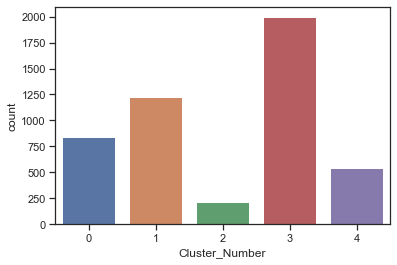

In [237]:
# Count plot of values per cluster
sns.countplot(x = "Cluster_Number",data = df_cl)

In [238]:
# Counts of unique values per rating
df_cl['Hospital overall rating'].value_counts()

3.000000    1772
3.073465    1170
4.000000     964
2.000000     684
1.000000     117
5.000000     111
Name: Hospital overall rating, dtype: int64

There are some entries with decimal values to round them off and get them to a whole number, we will change the datatype. 

In [239]:
# Changing datatype of the column 'Hospital overall rating'
df_cl['Hospital overall rating'] = df_cl['Hospital overall rating'].astype(int)

In [240]:
# Rechecking the count of unique values per rating
df_cl['Hospital overall rating'].value_counts()

3    2942
4     964
2     684
1     117
5     111
Name: Hospital overall rating, dtype: int64

In [241]:
# Average of weights is taken to figure of the newly assigned ratings 
df_cl.groupby('Cluster_Number')['weights'].mean()

Cluster_Number
0   -2.068379
1    1.146364
2   -5.111343
3   -0.111164
4    3.026831
Name: weights, dtype: float64

### Comparing cluster numbers with the mean of the weights we got following predicted ratings:-

Cluster Number-->Predicted Rating

  0        -->       2

  1        -->       1

  2        -->       5

  3        -->       4

  4        -->       3

In [242]:
# Creating df with required columns
cluster_df = df_cl[['Provider ID', 'Hospital overall rating', 'value1', 'value2', 'value3', 'value4', 'value5', 'value6',
'value7', 'weights', 'Cluster_Number']]
cluster_df.head()

,Provider ID,Hospital overall rating,value1,value2,value3,value4,value5,value6,value7,weights,Cluster_Number
0,10001,3,1.060013,-3.443864,0.656153,-2.052973e+00,-0.133261,3.864878,-0.563899,-0.705039,3
1,10005,3,4.799010,1.046338,-0.332511,1.527710e+00,-1.039917,-0.856808,1.235441,1.522469,1
2,10006,2,5.956441,-2.310250,-2.041427,-3.925341e+00,0.160477,-1.635511,0.550004,-0.547528,3
3,10007,3,3.146606,3.563607,-1.088042,2.057265e+00,3.837027,0.246321,1.501243,1.912859,1
4,10008,3,0.127309,2.929065,0.815200,1.512182e-14,0.040208,-2.632811,-0.341244,0.734392,1


In [243]:
# Assigning predicted ratings to clusters 
cluster_df['Cluster_Rating'] = cluster_df.Cluster_Number.apply(lambda x : 2 if x==0 else( 1 if x==1  else 5 if x==2 
else 4 if x==3 else 3))
cluster_df.head()

,Provider ID,Hospital overall rating,value1,value2,value3,value4,value5,value6,value7,weights,Cluster_Number,Cluster_Rating
0,10001,3,1.060013,-3.443864,0.656153,-2.052973e+00,-0.133261,3.864878,-0.563899,-0.705039,3,4
1,10005,3,4.799010,1.046338,-0.332511,1.527710e+00,-1.039917,-0.856808,1.235441,1.522469,1,1
2,10006,2,5.956441,-2.310250,-2.041427,-3.925341e+00,0.160477,-1.635511,0.550004,-0.547528,3,4
3,10007,3,3.146606,3.563607,-1.088042,2.057265e+00,3.837027,0.246321,1.501243,1.912859,1,1
4,10008,3,0.127309,2.929065,0.815200,1.512182e-14,0.040208,-2.632811,-0.341244,0.734392,1,1


**RECOMMENDATIONS FOR EVANSTON HOSPITAL:**

In [244]:
# Checking 'Evanston Hospital' data 
Evanston = cluster_df.loc[cluster_df['Provider ID']==140010]
Evanston

,Provider ID,Hospital overall rating,value1,value2,value3,value4,value5,value6,value7,weights,Cluster_Number,Cluster_Rating
1124,140010,3,-7.878275,-10.528007,-1.506548,-1.980363,-1.251821,1.092583,-0.388171,-4.838399,2,5


In [245]:
# Getting mean of value features for every cluster 
print("value1",cluster_df.groupby('Cluster_Rating')['value1'].mean())
print("value2",cluster_df.groupby('Cluster_Rating')['value2'].mean())
print("value3",cluster_df.groupby('Cluster_Rating')['value3'].mean())
print("value4",cluster_df.groupby('Cluster_Rating')['value4'].mean())
print("value5",cluster_df.groupby('Cluster_Rating')['value5'].mean())
print("value6",cluster_df.groupby('Cluster_Rating')['value6'].mean())
print("value7",cluster_df.groupby('Cluster_Rating')['value7'].mean())

value1 Cluster_Rating
1    0.541090
2   -0.674951
3    0.509431
4    0.003867
5   -1.776671
Name: value1, dtype: float64
value2 Cluster_Rating
1     2.174853
2    -3.030490
3     2.803026
4     0.466418
5   -11.982240
Name: value2, dtype: float64
value3 Cluster_Rating
1    0.329427
2   -0.222206
3    0.357123
4   -0.207108
5    0.001957
Name: value3, dtype: float64
value4 Cluster_Rating
1     2.236354
2    -5.681269
3    10.193982
4    -0.695391
5   -10.016741
Name: value4, dtype: float64
value5 Cluster_Rating
1    0.362624
2   -0.523754
3    0.384432
4   -0.107460
5   -0.006742
Name: value5, dtype: float64
value6 Cluster_Rating
1   -0.807350
2    1.874244
3   -1.290214
4   -0.287663
5    3.232953
Name: value6, dtype: float64
value7 Cluster_Rating
1    0.054331
2   -0.210933
3    0.326977
4   -0.006804
5   -0.254471
Name: value7, dtype: float64


**We will compare average values of cluster 5 with the values for each group for the Evanston Hospital. This will help us in drawing conclusions and give better recommendations.**

# Recommendations for Hospital EVANSTON HOSPITAL(140010):-

1.Mortality should be less than over all average so in our case we need to decrease it.

2.Safety of care should be above average in our case it's performing well.

3.Readmission the lesser it is the better it is therefore we need to reduce it as it's greater than average.

4.Patient experience should be greater than average therefore we should increase the value.

5.Effectiveness of care should be greater than average in our case it's performing well.

6.Timeliness of care should be greater than average in our case it's performing well.

7.Medical Imaging should be greater than average in our case it's performing well.